In [94]:
import utils
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import plotly.express as px
import numpy as np


# Préparation des données

In [140]:
players_info_list = utils.get_dataframes_csv_file('../data/players_infos')
players_stats_list = utils.get_dataframes_csv_file('../data/players_stats')

In [141]:
# Trier les données en fonction des années 
players_info_list.sort(key=lambda df: df['Title'][0].split('-')[0][-4:])
players_stats_list.sort(key=lambda df: df['Title'][0].split('-')[0][-4:])

In [142]:
# Selectionner depuis l'année 1980 pour les statistiques en raison du manques de statistiques avant les années 80s et enlever saison en cours
players_stats_list = players_stats_list[68:-1]

players_info_list = players_info_list[:-1]

In [143]:
# Diviser les données des stats des joueurs en fonctions du type de saison 
players_stats_list_summer_league = []
players_stats_list_playoffs = []
players_stats_list_regular_season = []
players_stats_list_preseason = []

for df in players_stats_list:
    year = df['Title'].iloc[0].split(' ')[1]

    if year == '2023-2024':
        continue

    season_type = df['Title'].iloc[0].split(' ')[2]
    
    # Ajouter les données au dictionnaire approprié
    if season_type == 'Playoffs':
        players_stats_list_playoffs.append(df)
    elif season_type == 'Regular_Season':
        players_stats_list_regular_season.append(df)
    elif season_type == 'Preseason':
        players_stats_list_preseason.append(df)

In [144]:
# Combiner les DataFrames en un seul pour chaque liste
players_info = pd.concat(players_info_list)
players_stats = pd.concat(players_stats_list_regular_season)

# Conversion de la colonne 'Title' pour extraire l'année de la saison
players_info['Season'] = players_info['Title'].apply(lambda x: x.split()[1])
players_stats['Season'] = players_stats['Title'].apply(lambda x: x.split()[1])

# Suppression des colonnes 'Title' après extraction de la saison
players_info.drop(columns=['Title'], inplace=True)
players_stats.drop(columns=['Title'], inplace=True)

# Jointure des DataFrames sur le nom des joueurs et la saison
merged_data = pd.merge(players_info, players_stats, on=['Player', 'Season', 'GP'], how='inner')

In [145]:
# Remplacer les positions par les 5 positions principale : PG - SG - SF - PF - C 
# Dictionnaire de mappage des positions
position_mapping = {
    'PG': ['PG'],
    'SG': ['SG'],
    'SF': ['SF'],
    'PF': ['PF'],
    'C': ['C'],
    'F': ['SF', 'PF'],
    'G': ['PG', 'SG'],
    'GF': ['SG', 'SF'],
    'FC': ['PF', 'C'],
    'F-C': ['PF', 'C'],
    'G-F': ['SG', 'SF', 'PF'],
    'C-F': ['C', 'PF'],
    'F-G': ['SG', 'SF', 'PF'],
}

# Fonction pour remplacer les positions par les listes correspondantes
def map_positions(pos):
    return position_mapping.get(pos, [pos])

# Application de la fonction de mappage à la colonne 'Pos'
merged_data['Pos'] = merged_data['Pos'].apply(map_positions)

In [146]:
# Calcul des statistiques par match et par minute pour les statistiques de jeu des joueurs
game_stats_cols = ['MIN', 'PTS', 'FGM', 'FGA', 'FG%', '3PM', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'ORB', 'DRB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF']

for col in game_stats_cols:
    if col[-1] != '%':
        merged_data[f'{col}_per_game'] = merged_data[col] / merged_data['GP']

for col in game_stats_cols[1:]:
    if col[-1] != '%':
        merged_data[f'{col}_per_min'] = merged_data[col] / merged_data['MIN']

In [147]:
# Sélection des colonnes pertinentes
info_cols = ['HT', 'WT']  # Taille et poids
stats_cols = [f'{col}_per_game' for col in game_stats_cols if col[-1] != '%']  # Statistiques de jeu par match
percentage_cols = ['FG%', '3P%', 'FT%']
stats_cols_per_min = [f'{col}_per_min' for col in game_stats_cols if col[-1] != '%' and col != 'MIN']  # Statistiques de jeu par minute
all_cols = info_cols + stats_cols + percentage_cols

# Filtrer les données pour inclure uniquement les colonnes pertinentes (ici on inclue les colonnes des stats par matchs et les informations physiques des joueurs)
filtered_data = merged_data[all_cols]

In [148]:
# Les informations qu'on a 
merged_data.columns

Index(['Player', 'Pos', 'HT', 'WT', 'Age', 'Teams', 'GP', 'YOS', 'Nationality',
       'Season', 'Team', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%', '3PM', '3PA',
       '3P%', 'FTM', 'FTA', 'FT%', 'ORB', 'DRB', 'REB', 'AST', 'STL', 'BLK',
       'TOV', 'PF', 'MIN_per_game', 'PTS_per_game', 'FGM_per_game',
       'FGA_per_game', '3PM_per_game', '3PA_per_game', 'FTM_per_game',
       'FTA_per_game', 'ORB_per_game', 'DRB_per_game', 'REB_per_game',
       'AST_per_game', 'STL_per_game', 'BLK_per_game', 'TOV_per_game',
       'PF_per_game', 'PTS_per_min', 'FGM_per_min', 'FGA_per_min',
       '3PM_per_min', '3PA_per_min', 'FTM_per_min', 'FTA_per_min',
       'ORB_per_min', 'DRB_per_min', 'REB_per_min', 'AST_per_min',
       'STL_per_min', 'BLK_per_min', 'TOV_per_min', 'PF_per_min'],
      dtype='object')

# Etude de la distibution des variables 

#### Violin Plot

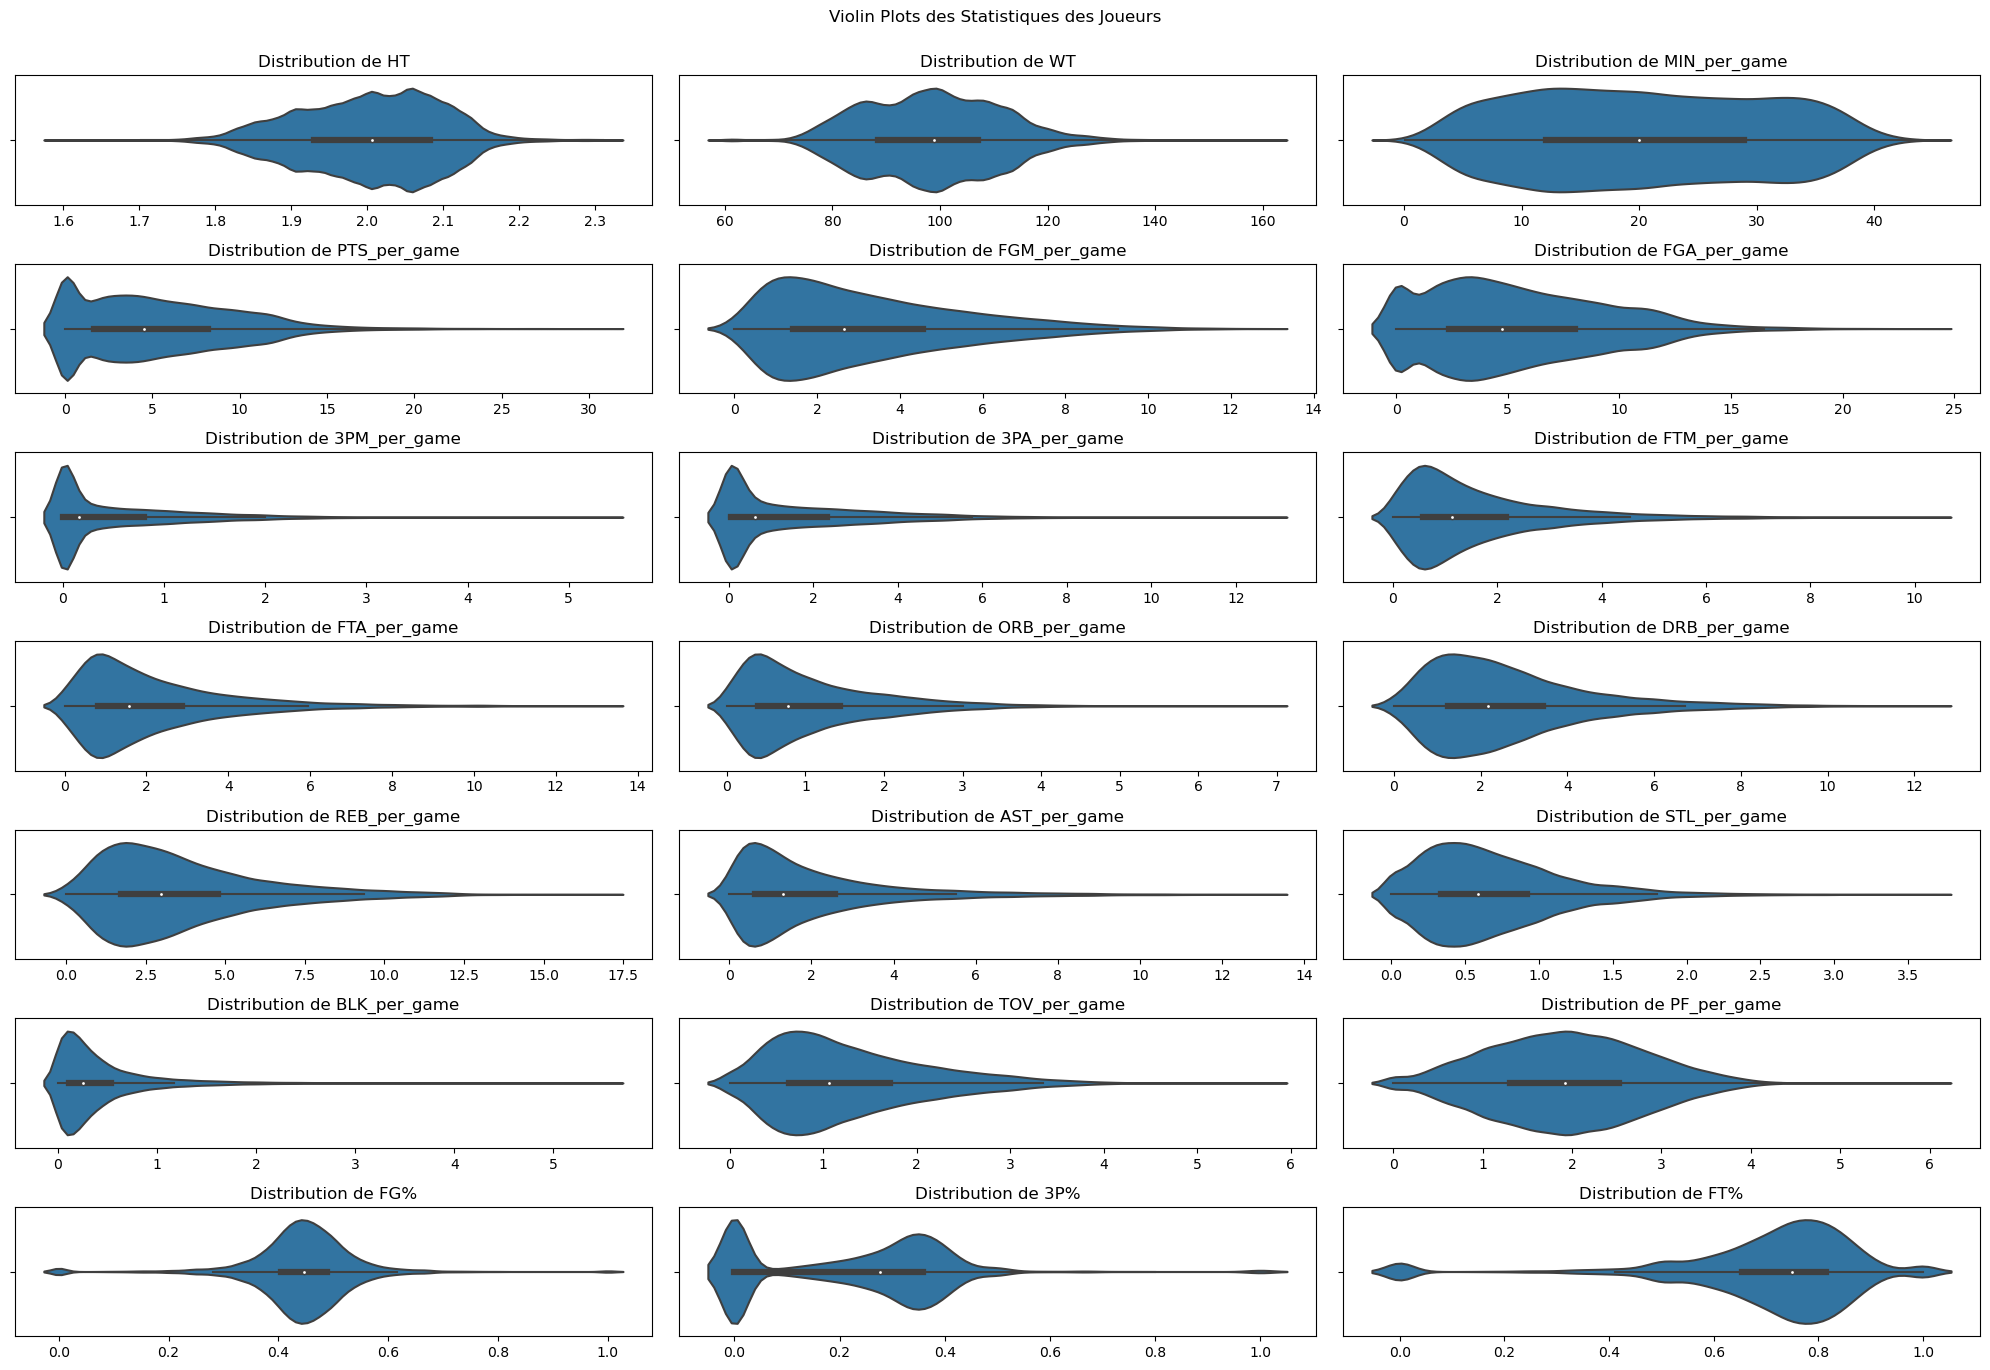

In [83]:
# Violin plot pour visualiser la distribution des statistiques
plt.figure(figsize=(20, 15))
for i, col in enumerate(filtered_data.columns, 1):
    plt.subplot(len(filtered_data.columns) // 3 + 1, 3, i)
    sns.violinplot(data=filtered_data, x=col)
    plt.title(f'Distribution de {col}')
    plt.xlabel('')
plt.tight_layout()
plt.suptitle('Violin Plots des Statistiques des Joueurs', y=1.02)
plt.show()

#### Observations :

- La taille (HT) des joueurs est concentrée autour de 1.9 à 2.1 mètres.

- Le poids (WT) des joueurs varie principalement entre 80 et 120 kg, avec une concentration plus élevée autour de 90 à 110 kg.

- MIN_per_game (Minutes par match) :
La plupart des joueurs jouent entre 15 et 30 minutes par match, avec quelques outliers jouant plus de 35 minutes.

- PTS_per_game (Points par match) :
La distribution des points par match montre que la majorité des joueurs marquent entre 5 et 15 points par match. Il y a quelques joueurs qui marquent plus de 25 points par match, mais ils sont rares.

- FGM_per_game (Field Goals Made par match) et FGA_per_game (Field Goals Attempted par match) :
Les tentatives de tirs (FGA_per_game) sont plus dispersées, avec une concentration entre 5 et 15 tirs par match. Les réussites de tirs (FGM_per_game) suivent une distribution similaire, mais avec des valeurs légèrement inférieures, ce qui est attendu.

- FG% (Field Goal Percentage par match) :
Le pourcentage de réussite aux tirs est principalement concentré entre 0.4 et 0.6 (40% à 60%).

- 3PM_per_game (3-Points Made par match) et 3PA_per_game (3-Points Attempted par match) :
Les tentatives de tirs à trois points (3PA_per_game) sont concentrées autour de 0 à 4 tentatives par match, tandis que les réussites (3PM_per_game) sont principalement entre 0 et 2 réussites par match.

- 3P% (3-Points Percentage par match) :
Le pourcentage de réussite aux tirs à trois points est principalement concentré entre 0.2 et 0.4 (20% à 40%).

- FTM_per_game (Free Throws Made par match) et FTA_per_game (Free Throws Attempted par match) :
Les lancers francs tentés (FTA_per_game) et réussis (FTM_per_game) montrent des distributions similaires, avec des valeurs typiquement entre 0 et 5 par match.

- FT% (Free Throw Percentage par match) :
Le pourcentage de réussite aux lancers francs est principalement concentré entre 0.6 et 0.9 (60% à 90%).

- ORB_per_game (Offensive Rebounds par match), DRB_per_game (Defensive Rebounds par match) et REB_per_game (Total Rebounds par match) :
Les rebonds offensifs (ORB_per_game) sont principalement entre 0 et 3 par match, tandis que les rebonds défensifs (DRB_per_game) montrent une plus grande variabilité, avec une concentration entre 3 et 8 rebonds par match. Les rebonds totaux (REB_per_game) suivent une distribution similaire à celle des rebonds défensifs, mais avec des valeurs légèrement supérieures.

- AST_per_game (Assists par match) :
Les passes décisives par match sont principalement concentrées entre 0 et 7, avec quelques joueurs ayant des valeurs plus élevées.

- STL_per_game (Steals par match) et BLK_per_game (Blocks par match) :
Les vols (STL_per_game) et les contres (BLK_per_game) sont principalement concentrés entre 0 et 2 par match.

- TOV_per_game (Turnovers par match) :
Les turnovers par match montrent une distribution principalement entre 0 et 4.

- PF_per_game (Personal Fouls par match) :
Les fautes personnelles par match sont principalement concentrées entre 1 et 3.

#### Passant maintenant à des analyses plus approfondies

# Analyse des informations deu joueurs

#### Résumé statistique global pour les informations des joueurs

In [84]:
player_info_stats = merged_data[['HT', 'WT', 'GP']].describe().transpose()
player_info_stats_df = player_info_stats[['mean', '50%', 'std', 'min', 'max']]
player_info_stats_df.columns = ['Mean', 'Median', 'StdDev', 'Min', 'Max']
display(player_info_stats_df)

Mean     Median     StdDev        Min         Max
HT   2.003504   2.006600   0.092664   1.600200    2.311400
WT  98.637015  98.883137  12.498294  60.327785  161.025291
GP  53.444178  61.000000  25.339353   1.000000   85.000000

#### Résumé statistique par saison pour les informations des joueurs

In [85]:
seasonal_info_summary = merged_data.groupby('Season')[['HT', 'WT', 'GP']].describe().transpose()
print("Résumé statistique par saison pour les informations des joueurs:")
print(seasonal_info_summary)

Résumé statistique par saison pour les informations des joueurs:
Season     1980-1981   1981-1982   1982-1983   1983-1984   1984-1985  \
HT count  265.000000  298.000000  268.000000  270.000000  304.000000   
   mean     1.992414    1.994411    2.000250    2.000956    2.000166   
   std      0.089384    0.084620    0.089678    0.089457    0.088945   
   min      1.727200    1.727200    1.727200    1.727200    1.727200   
   25%      1.930400    1.930400    1.930400    1.930400    1.930400   
   50%      2.006600    2.006600    2.006600    2.006600    2.006600   
   75%      2.057400    2.057400    2.057400    2.057400    2.057400   
   max      2.184400    2.184400    2.260600    2.235200    2.260600   
WT count  265.000000  297.000000  268.000000  270.000000  304.000000   
   mean    92.529420   92.664187   93.348633   93.675224   93.869747   
   std     10.168801   10.121542   10.573203   10.677278   10.468626   
   min     68.038855   68.038855   68.038855   68.038855   72.574779   

#### Affichage des évolutions temporelles des informations des joueurs

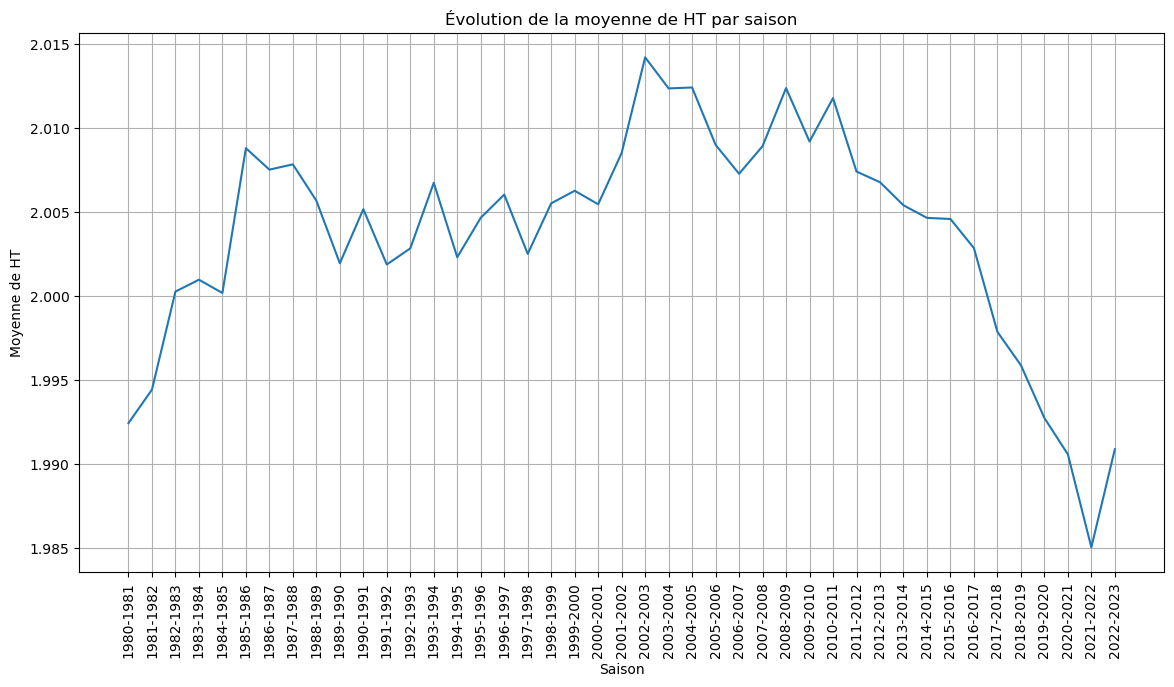

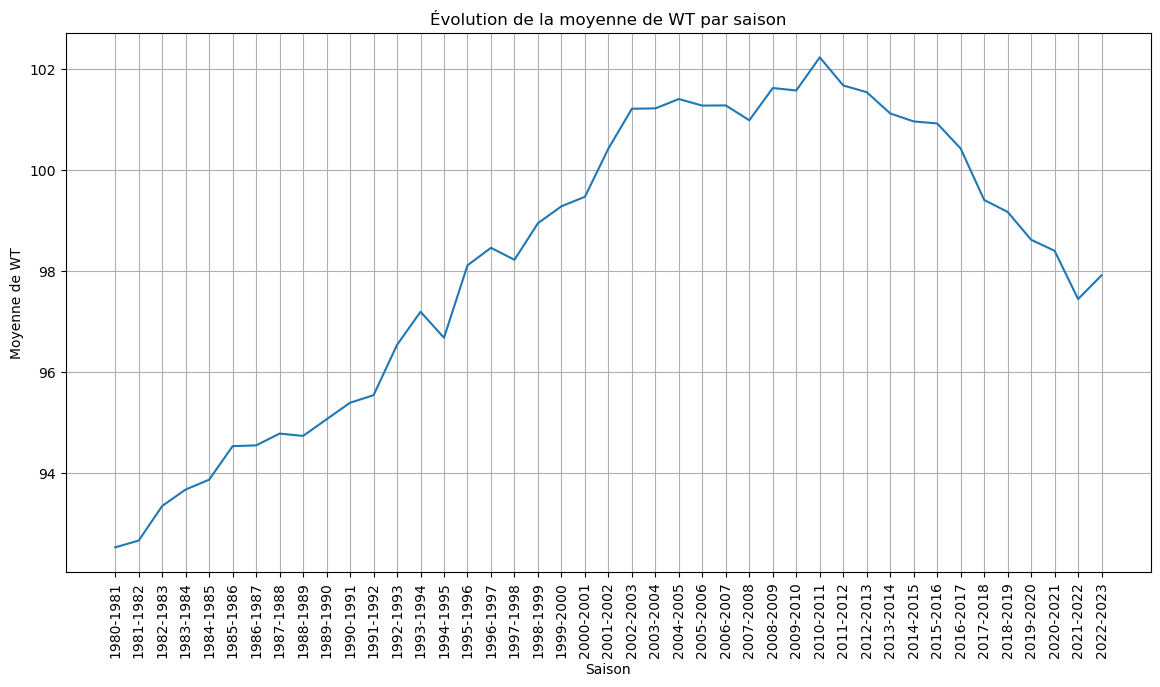

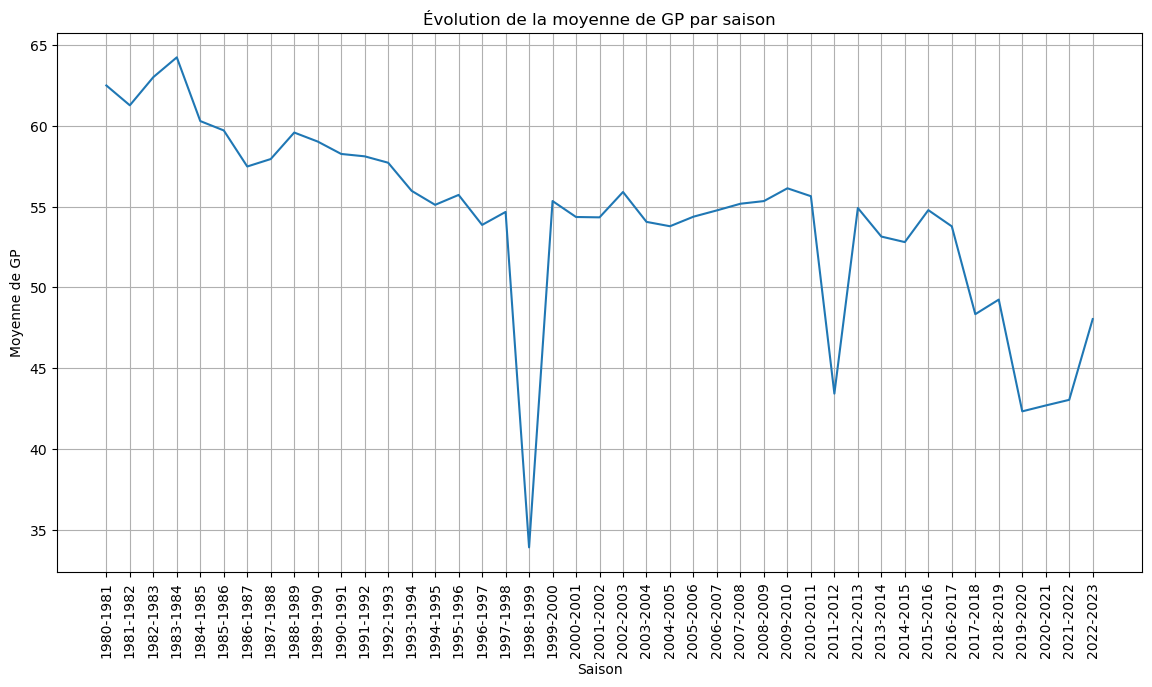

In [86]:
info_stats_to_plot = ['HT', 'WT', 'GP']

for stat in info_stats_to_plot:
    seasonal_mean_info = merged_data.groupby('Season')[stat].mean()
    plt.figure(figsize=(14, 7))
    sns.lineplot(data=seasonal_mean_info)
    plt.title(f"Évolution de la moyenne de {stat} par saison")
    plt.xlabel("Saison")
    plt.ylabel(f"Moyenne de {stat}")
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.show()

# Conclusion par rapport aux informations des joueurs 

- La tailles des joueurs ne varie pas en fonction des années et reste aux alentours des 2 mètres
- Le poid des joueurs varie l'égerement par rapport aux années mais reste entre 93 kg et 102 kg
- Les matches par saisons varie en foncton des années :
 
    Certaines saisons ont moins de matchs joué que d'autres pour différentes raisons :
    - la saison 1999-2000 est la saison avec le moins de matches joués, cela est du à un raccourcissement de la saison : En raison du retard causé par une grève des joueurs qui a duré 191 jours.
    - La saison 2011-2012 à subit un retardement du  début de la saison
    - Les saisons 2019-2020, 2020-2021, 2021-2022 ont était impacté par la pandemie du COVID-19

    En globalité, les matchs par saisons sont en diminution au fil des années.
    
    Hypothése : il y'a plus de joueurs disponible par equipe au fil des années.

# Players statistics

#### Résumé statistique global pour les statistiques par match des joueurs

In [87]:
player_game_stats_per_game = merged_data[stats_cols + percentage_cols].describe().transpose()
player_game_stats_per_game_df = player_game_stats_per_game[['mean', '50%', 'std', 'min', 'max']]
player_game_stats_per_game_df.columns = ['Mean', 'Median', 'StdDev', 'Min', 'Max']
display(player_game_stats_per_game_df)


Mean     Median     StdDev  Min        Max
MIN_per_game  20.472417  19.952094  10.095908  0.1  43.700000
PTS_per_game   5.232574   4.541667   4.350047  0.0  30.727273
FGM_per_game   3.206330   2.661017   2.285539  0.0  12.717949
FGA_per_game   5.369934   4.750000   3.893319  0.0  23.764706
3PM_per_game   0.489997   0.157895   0.666747  0.0   5.349206
3PA_per_game   1.414738   0.620471   1.762798  0.0  12.714286
FTM_per_game   1.581817   1.138462   1.438048  0.0  10.291139
FTA_per_game   2.111563   1.582806   1.812237  0.0  13.135135
ORB_per_game   1.029323   0.774194   0.862649  0.0   6.888889
DRB_per_game   2.581791   2.173623   1.818880  0.0  12.338710
REB_per_game   3.559137   2.972973   2.483984  0.0  16.795918
AST_per_game   1.915876   1.307692   1.865910  0.0  13.059701
STL_per_game   0.671337   0.583333   0.471736  0.0   3.658537
BLK_per_game   0.421660   0.256950   0.503149  0.0   5.560976
TOV_per_game   1.253262   1.064516   0.828420  0.0   5.728395
PF_per_game    1.925547   1.919677   0.856403  0.0   6.000000
FG%            0.441767   0.446000   0.097355  0.0   1.000000
3P%            0.224068   0.276500   0.180027  0.0   1.000000
FT%            0.703588   0.749000   0.189939  0.0   1.000000

#### Affichage des évolutions temporelles des statistiques par match des joueurs

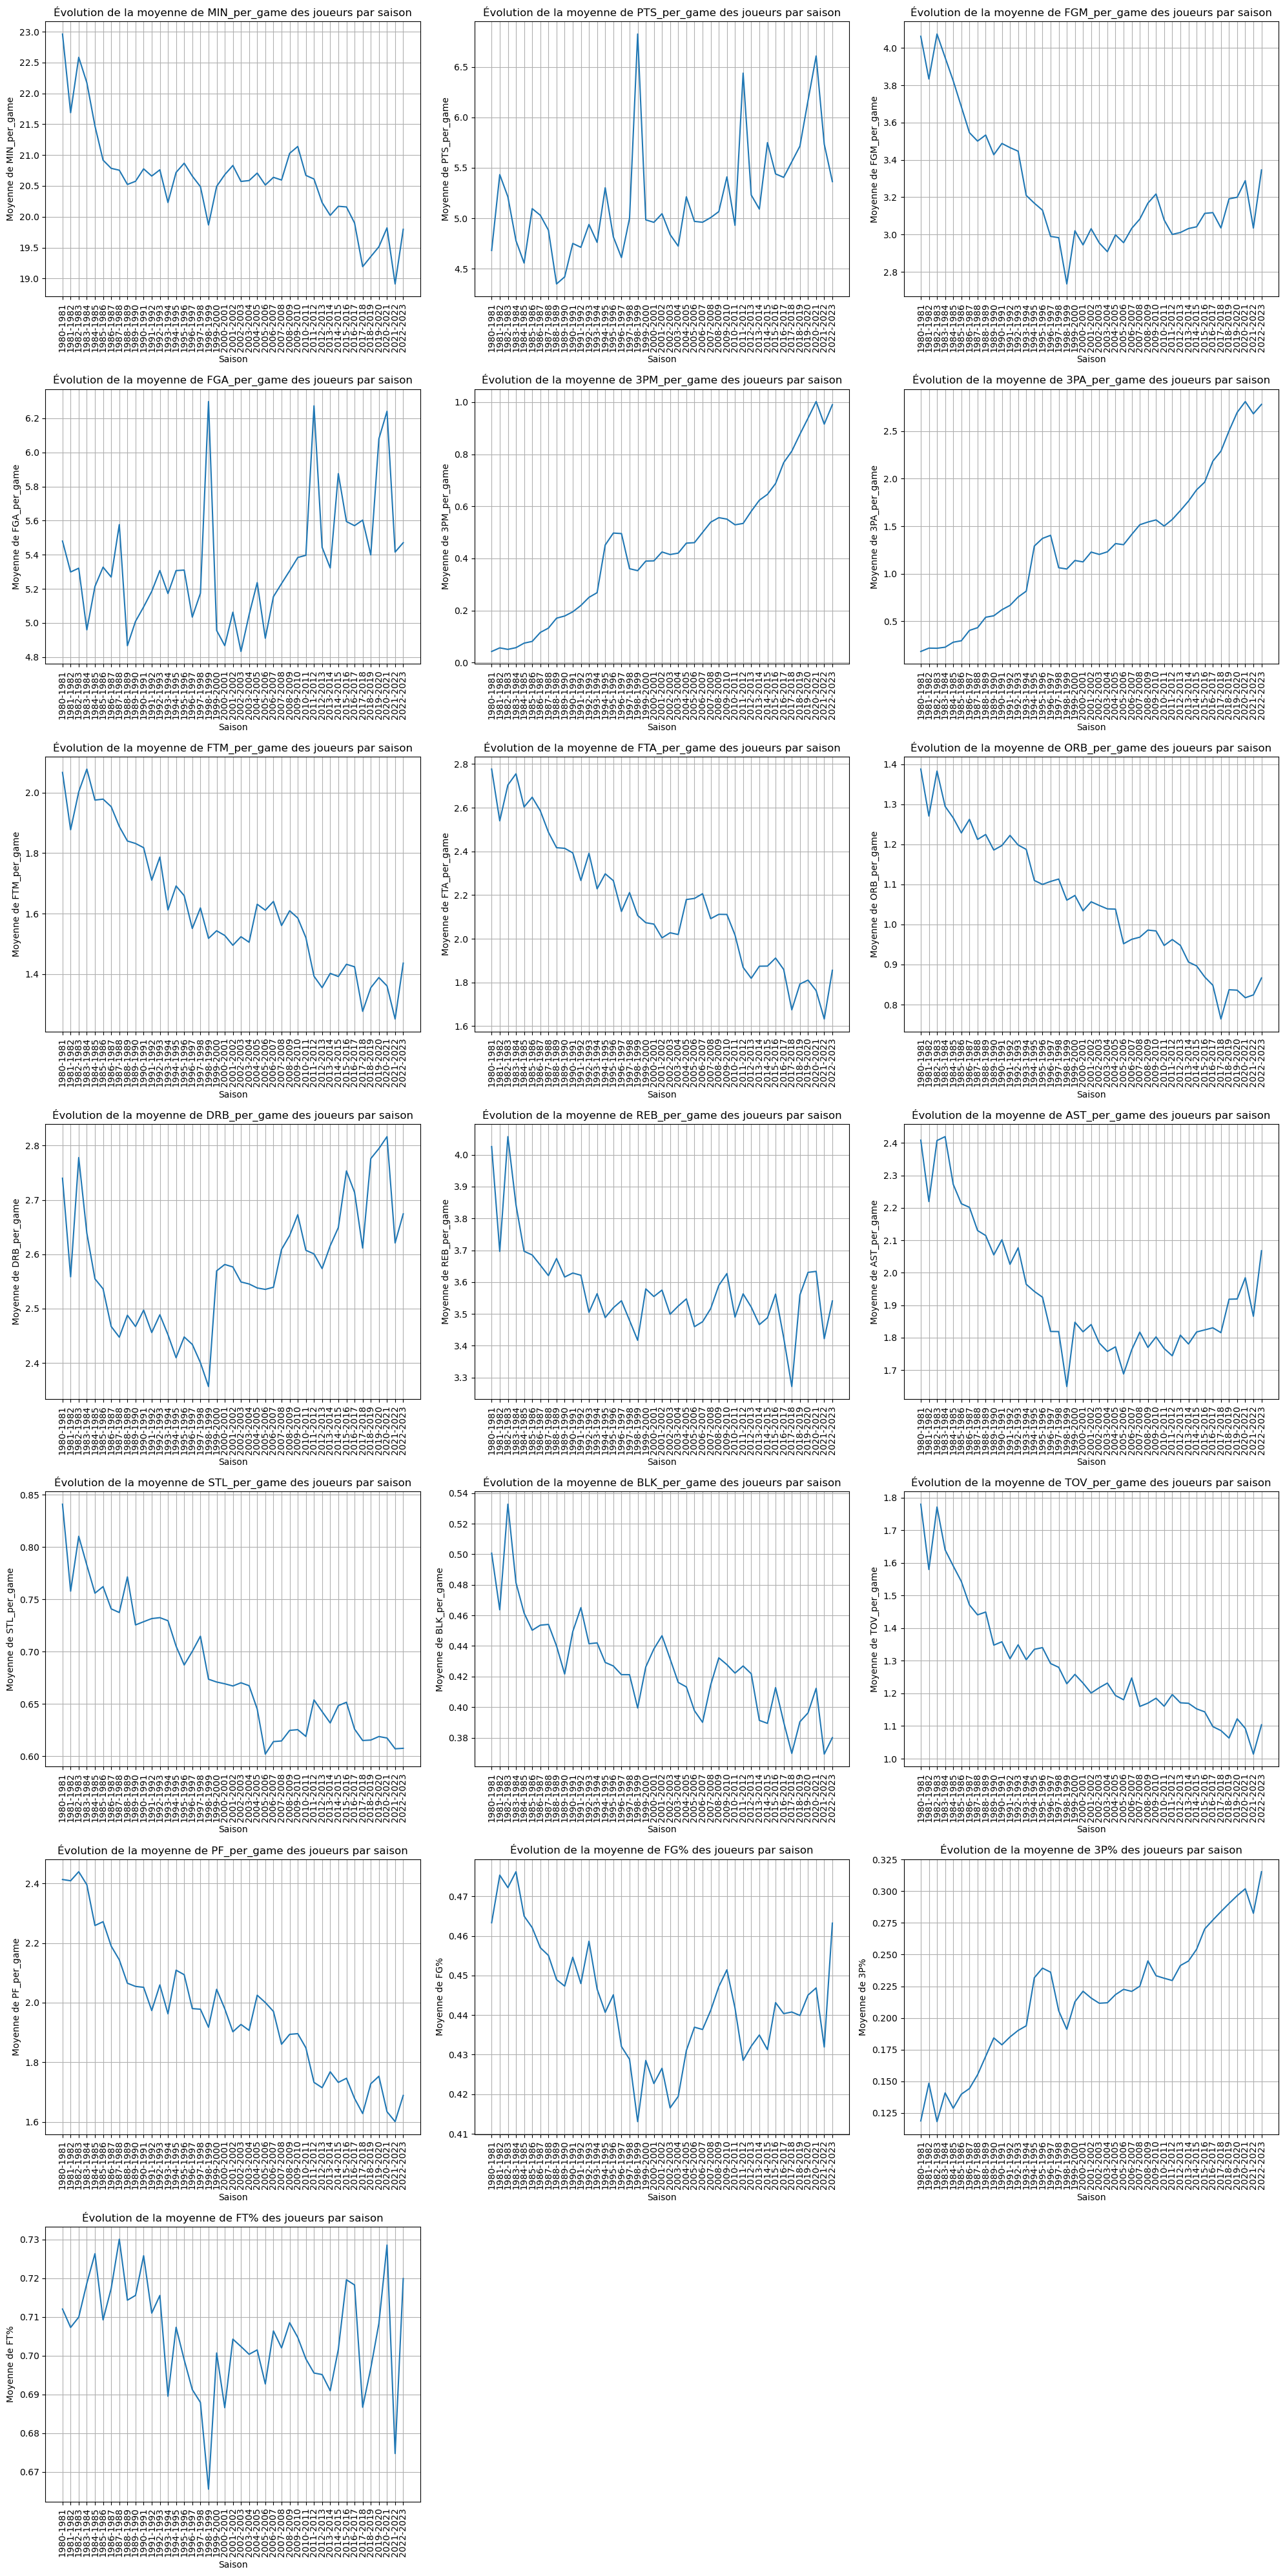

In [88]:
game_stats_per_game_to_plot = stats_cols + percentage_cols

# Définir la taille de la grille
n_cols = 3
n_rows = (len(game_stats_per_game_to_plot) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 40))
axes = axes.flatten()

for i, stat in enumerate(game_stats_per_game_to_plot):
    # Calculer la moyenne par saison pour la statistique actuelle
    seasonal_mean_game_per_game = merged_data.groupby('Season')[stat].mean()
    
    # Tracer la ligne pour la statistique actuelle sur l'axe approprié
    sns.lineplot(data=seasonal_mean_game_per_game, ax=axes[i])
    
    # Définir le titre et les labels des axes
    axes[i].set_title(f"Évolution de la moyenne de {stat} des joueurs par saison")
    axes[i].set_xlabel("Saison")
    axes[i].set_ylabel(f"Moyenne de {stat}")
    
    # Rotation des étiquettes de l'axe x pour une meilleure lisibilité
    axes[i].tick_params(axis='x', rotation=90)
    
    # Activer la grille pour une meilleure lisibilité
    axes[i].grid(True)

# Supprimer les axes vides si le nombre de stats n'est pas un multiple de n_cols
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Ajuster l'espacement entre les sous-plots
plt.subplots_adjust(hspace=0.4, wspace=0.3)

plt.tight_layout()
plt.show()


#### Affichage des évolutions temporelles des statistiques par minute des joueurs

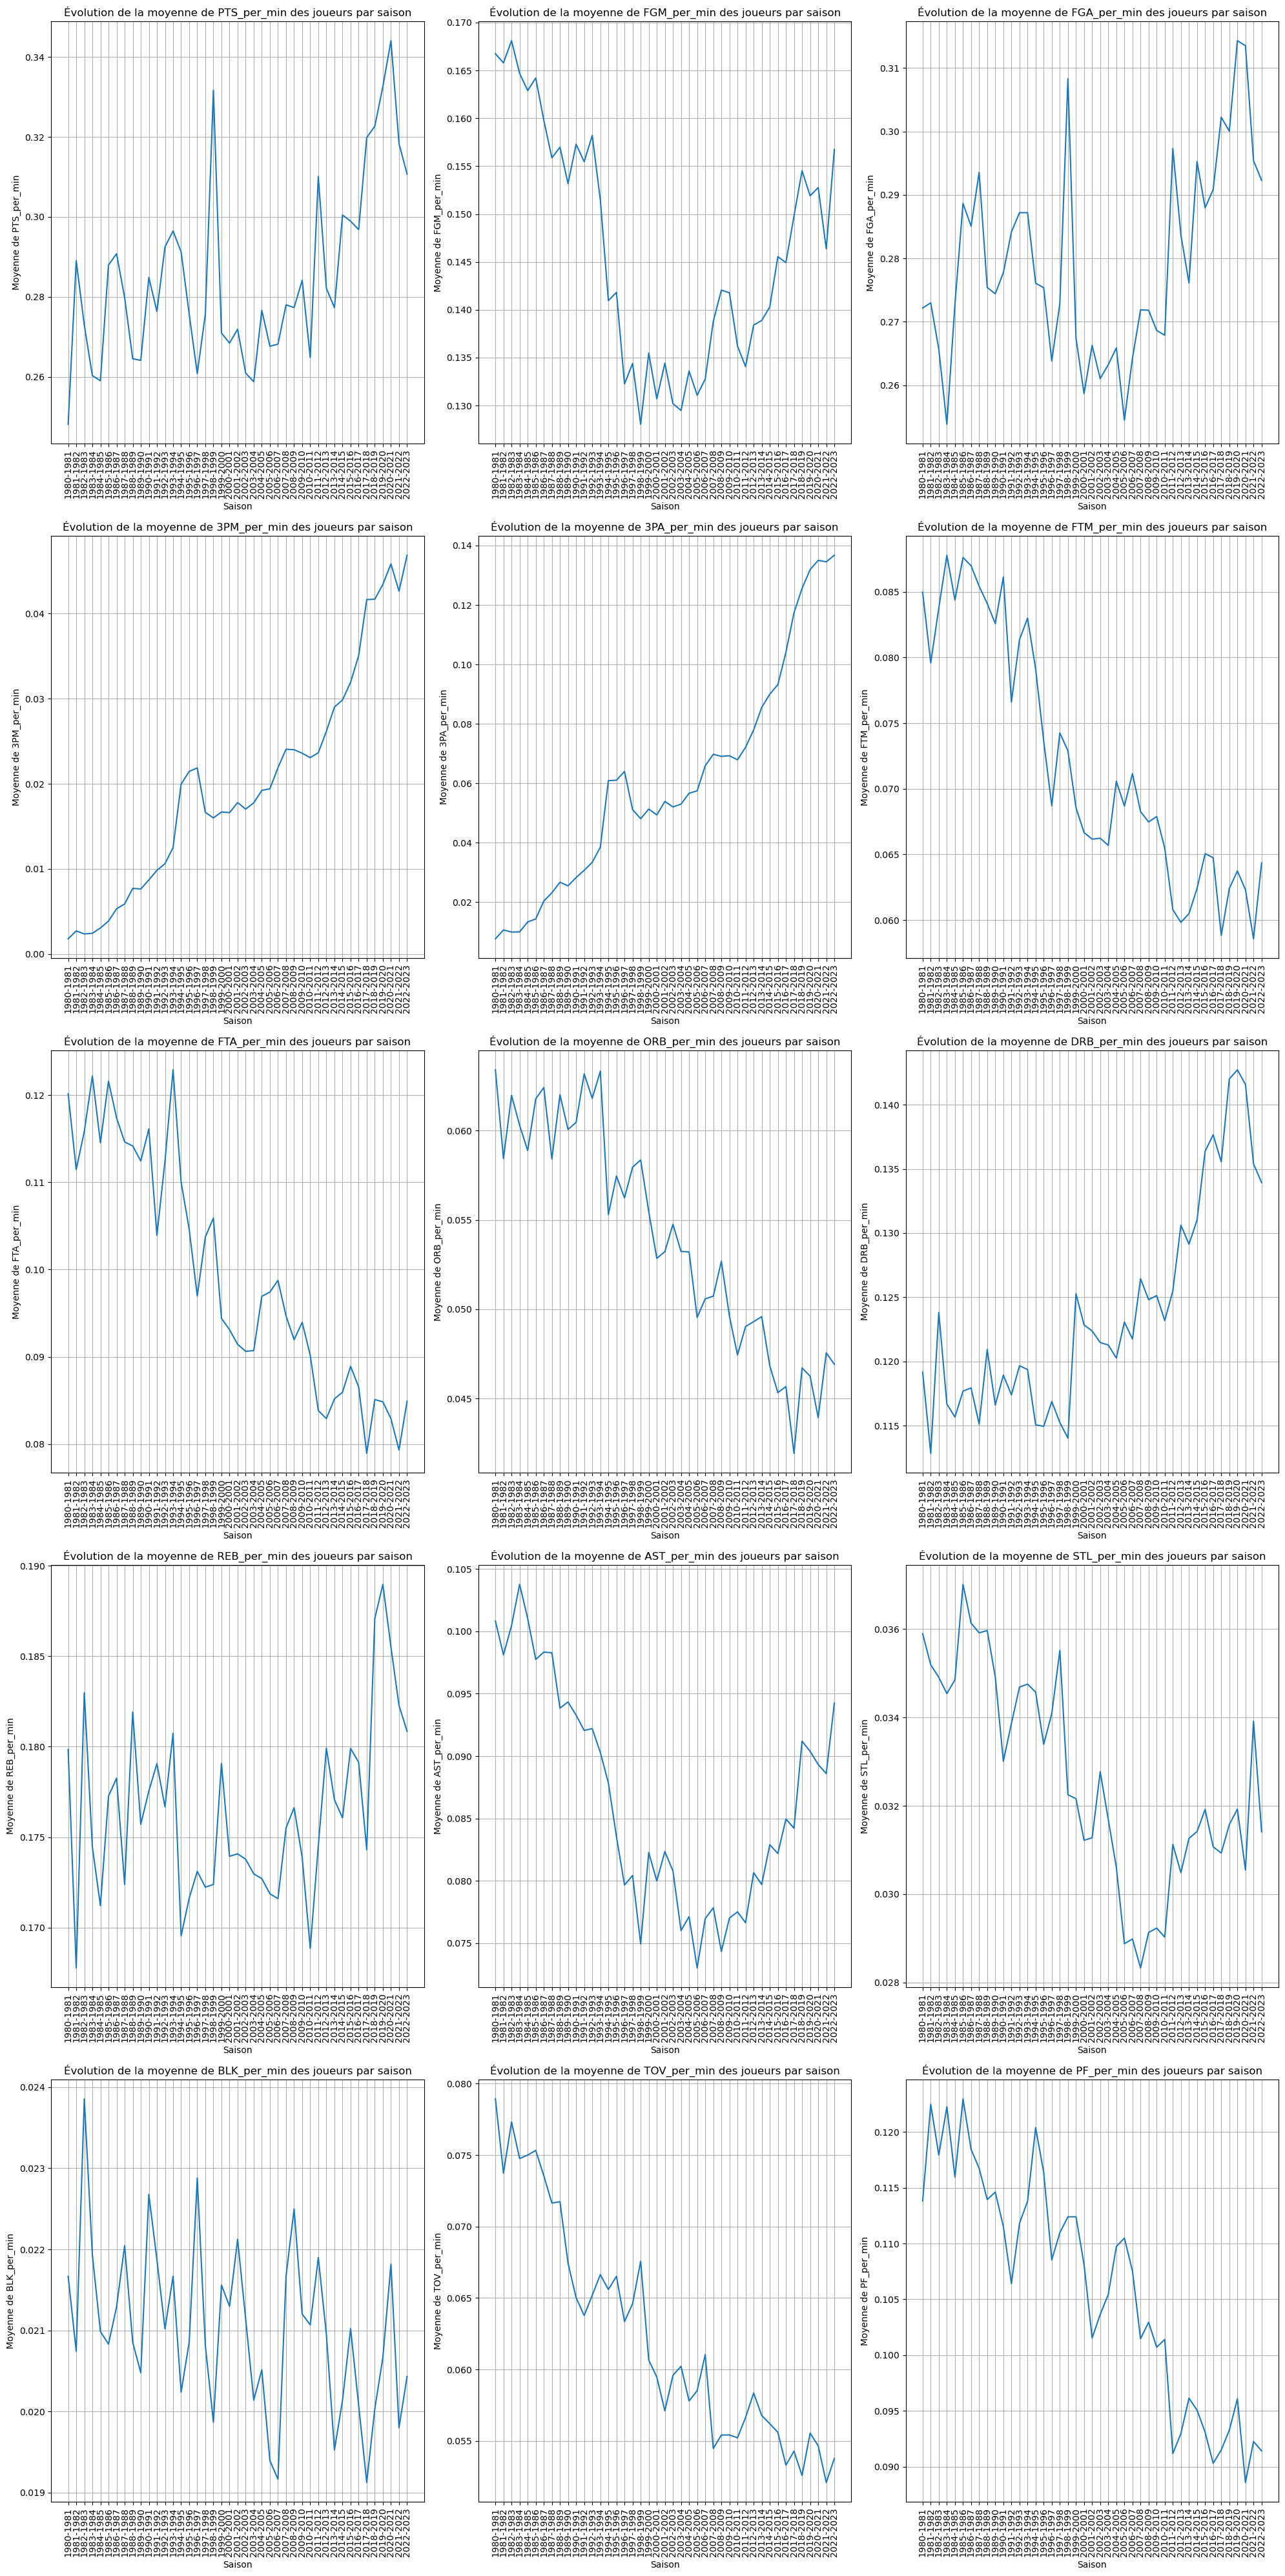

In [89]:
game_stats_per_game_to_plot = stats_cols_per_min

# Définir la taille de la grille
n_cols = 3
n_rows = (len(game_stats_per_game_to_plot) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 40))
axes = axes.flatten()

for i, stat in enumerate(game_stats_per_game_to_plot):
    # Calculer la moyenne par saison pour la statistique actuelle
    seasonal_mean_game_per_game = merged_data.groupby('Season')[stat].mean()
    
    # Tracer la ligne pour la statistique actuelle sur l'axe approprié
    sns.lineplot(data=seasonal_mean_game_per_game, ax=axes[i])
    
    # Définir le titre et les labels des axes
    axes[i].set_title(f"Évolution de la moyenne de {stat} des joueurs par saison")
    axes[i].set_xlabel("Saison")
    axes[i].set_ylabel(f"Moyenne de {stat}")
    
    # Rotation des étiquettes de l'axe x pour une meilleure lisibilité
    axes[i].tick_params(axis='x', rotation=90)
    
    # Activer la grille pour une meilleure lisibilité
    axes[i].grid(True)

# Supprimer les axes vides si le nombre de stats n'est pas un multiple de n_cols
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Ajuster l'espacement entre les sous-plots
plt.subplots_adjust(hspace=0.4, wspace=0.3)

plt.tight_layout()
plt.show()


In [90]:
# Affichage propre des résumés statistiques par saison pour les statistiques de jeu des joueurs
seasonal_game_summary_df = merged_data.groupby('Season').agg({
    'GP': ['mean', 'median', 'std', 'min', 'max'],
    'MIN': ['mean', 'median', 'std', 'min', 'max'],
    'PTS': ['mean', 'median', 'std', 'min', 'max'],
    'FGM': ['mean', 'median', 'std', 'min', 'max'],
    'FGA': ['mean', 'median', 'std', 'min', 'max'],
    'FG%': ['mean', 'median', 'std', 'min', 'max'],
    '3PM': ['mean', 'median', 'std', 'min', 'max'],
    '3PA': ['mean', 'median', 'std', 'min', 'max'],
    '3P%': ['mean', 'median', 'std', 'min', 'max'],
    'FTM': ['mean', 'median', 'std', 'min', 'max'],
    'FTA': ['mean', 'median', 'std', 'min', 'max'],
    'FT%': ['mean', 'median', 'std', 'min', 'max'],
    'ORB': ['mean', 'median', 'std', 'min', 'max'],
    'DRB': ['mean', 'median', 'std', 'min', 'max'],
    'REB': ['mean', 'median', 'std', 'min', 'max'],
    'AST': ['mean', 'median', 'std', 'min', 'max'],
    'STL': ['mean', 'median', 'std', 'min', 'max'],
    'BLK': ['mean', 'median', 'std', 'min', 'max'],
    'TOV': ['mean', 'median', 'std', 'min', 'max'],
    'PF': ['mean', 'median', 'std', 'min', 'max'],
})

print("Résumé statistique par saison pour les statistiques de jeu des joueurs:")
display(seasonal_game_summary_df)


Résumé statistique par saison pour les statistiques de jeu des joueurs:


GP                                    MIN           \
                mean median        std min max         mean   median   
Season                                                                 
1980-1981  62.503759   75.0  24.952521   1  84  1588.139098  1686.00   
1981-1982  61.275168   74.0  24.576099   1  84  1477.607383  1516.50   
1982-1983  63.018657   75.5  23.752698   3  83  1565.548507  1567.00   
1983-1984  64.244444   76.0  23.440335   1  82  1590.266667  1725.50   
1984-1985  60.299342   72.0  24.755155   1  82  1451.871711  1476.00   
1985-1986  59.720000   72.0  25.168661   1  83  1401.913846  1389.00   
1986-1987  57.486567   68.0  26.006545   1  82  1359.970448  1303.00   
1987-1988  57.948795   69.0  25.425095   1  84  1370.602410  1258.50   
1988-1989  59.589235   70.0  24.392356   1  82  1402.726346  1338.00   
1989-1990  59.031496   71.0  25.129435   1  82  1403.572178  1367.00   
1990-1991  58.263566   70.0  25.262001   1  82  1383.103359  1355.00   
1991-1992  58.116580   67.0  24.913552   1  84  1386.813472  1340.50   
1992-1993  57.720513   69.0  24.884646   2  83  1372.205128  1365.50   
1993-1994  55.980149   67.0  26.045876   1  82  1324.590571  1236.00   
1994-1995  55.113022   62.0  25.282288   1  82  1315.995086  1144.00   
1995-1996  55.727273   64.0  25.325687   1  83  1339.324242  1219.00   
1996-1997  53.870748   62.0  25.871783   1  83  1304.240590  1066.00   
1997-1998  54.674260   62.0  25.760950   1  82  1310.068337  1236.00   
1998-1999  33.909091   39.0  16.401870   1  50   796.932045   763.00   
1999-2000  55.348519   63.0  25.766854   1  85  1308.132118  1208.00   
2000-2001  54.360544   62.0  25.691335   1  83  1305.034014  1182.00   
2001-2002  54.338636   63.0  25.223942   1  83  1306.068182  1239.00   
2002-2003  55.908879   66.0  25.616220   1  83  1344.434579  1321.00   
2003-2004  54.058824   61.0  25.721889   1  85  1300.378054  1186.50   
2004-2005  53.788793   63.0  25.251106   1  84  1282.317026  1213.50   
2005-2006  54.379913   61.0  24.488639   1  82  1300.344541  1202.60   
2006-2007  54.770742   63.0  24.446831   1  82  1300.784498  1296.40   
2007-2008  55.181818   65.0  25.085768   2  82  1317.303326  1316.00   
2008-2009  55.346067   63.0  24.624326   1  82  1336.297753  1225.00   
2009-2010  56.138009   64.5  24.131376   1  82  1345.018326  1310.75   
2010-2011  55.648230   62.5  23.940478   1  83  1316.488496  1236.05   
2011-2012  43.426778   49.0  19.810049   1  66  1002.204603   939.40   
2012-2013  54.918977   61.0  24.367772   1  82  1267.535608  1187.90   
2013-2014  53.149378   61.0  25.399725   1  83  1234.861203  1136.05   
2014-2015  52.806911   61.0  24.344049   1  83  1209.765650  1192.05   
2015-2016  54.785714   62.0  24.274576   1  82  1249.692227  1228.90   
2016-2017  53.781893   62.5  24.838733   1  82  1223.076132  1197.45   
2017-2018  48.344444   55.5  27.460545   1  82  1099.731667  1038.75   
2018-2019  49.247170   56.0  26.048763   1  82  1121.610189  1068.60   
2019-2020  42.328922   48.0  22.633224   1  74   968.005104   921.90   
2020-2021  42.692593   46.0  20.706670   1  72   965.750185   925.55   
2021-2022  43.041322   48.0  25.815570   1  82   981.412066   883.30   
2022-2023  48.040816   54.0  24.650686   1  83  1103.623933   969.80   

                                      ...         TOV                        \
                   std   min     max  ...        mean median        std min   
Season                                ...                                     
1980-1981   931.645973   5.0  3417.0  ...  121.537594  125.5  77.840624   0   
1981-1982   920.289716   6.0  3398.0  ...  107.291946  104.0  73.631158   0   
1982-1983   908.363430  12.0  3093.0  ...  122.791045  118.0  79.873268   0   
1983-1984   926.119680   3.0  3082.0  ...  116.448148  115.5  76.177761   0   
1984-1985   941.769197   7.0  3182.0  ...  106.197368   98.0  76.679784   0   
1985-1986   913.854281   2.0  3258.0  ...  101.590769   91.0  75.012068  

# Conclusion et Hypothèses par rapport aux statistiques de jeu des joueurs 

On remarque d'abord que les analyses des statistiques par match et par minute sont similaires. Par conséquent, nous allons nous concentrer sur les analyses des statistiques par match, car elles sont plus significatives (dans le sens ou ça nous parle plus)

- En globalité, le nombre de minutes jouées par partie en moyenne diminue très légèrement au fil des années.
    - Hypothèse : Peut-être plus de joueurs par équipe, donc chaque joueur joue un peu moins.



- Le nombre de paniers à 3 points marqués par joueur par match augmente en moyenne au fil du temps, passant de un peu plus de 0 au début des années 80 à 1 panier à 3 points marqué par joueur par match actuellement.
Comme le nombre de paniers à 3 points marqués, le nombre de tentatives de tirs à 3 points a aussi augmenté.
- Le pourcentage de tirs à 3 points réussis a aussi augmenté.
    - Hypothèse : Les joueurs se sont améliorés au tir à 3 points.

- Le nombre de lancers francs et de tentatives de lancers francs ont diminué au fil du temps, passant d'environ 2 à environ 1,2 pour les lancers francs, et de 2,8 à 1,6 pour les tentatives.
- Le pourcentage de lancers francs réussis a quant à lui légèrement augmenté au fil du temps.
    - Hypothèse : Les joueurs sont devenus meilleurs aux lancers francs, mais il y a moins de tentatives (ce qui mène à moins de points marqués sur les lancers francs). Cela peut être dû à plusieurs facteurs comme les règles de défense plus souples, les styles de jeu plus intérieurs, l'arbitrage plus permissif et le rythme de jeu plus lent.

- Le nombre de rebonds offensifs en moyenne par match par joueur a diminué, passant de 1,4 à 0,8.
- Le nombre d'interceptions en moyenne par match par joueur a diminué, passant de 0,85 à 0,60.
- Le nombre de contres en moyenne par match par joueur a diminué, passant de 0,5 à 0,38.
- Le nombre de ballons perdus en moyenne par match par joueur a diminué, passant de 1,8 à 1.
- Le nombre de fautes personnelles en moyenne par match par joueur a diminué, passant de 2,4 à 1,6.



##### Hypothèse Globale : 
Ces évolutions statistiques observées au fil du temps dans la NBA reflètent probablement des changements dans les styles de jeu, les stratégies et les règles de la ligue.
L'augmentation du nombre de tirs à 3 points et de leur pourcentage de réussite suggère que le jeu est devenu plus axé sur le tir extérieur et le jeu rapide.
La diminution du nombre de lancers francs et de tentatives pourrait s'expliquer par une défense devenue plus permissive, favorisant les duels au poste bas.
La baisse des rebonds offensifs, d'interceptions et de contres indique peut-être une transition vers un jeu plus fluide et athlétique, avec moins de confrontations physiques sous le panier.
La diminution des fautes personnelles pourrait refléter une application plus stricte des règles par les arbitres, limitant le jeu rugueux.
Dans l'ensemble, ces tendances semblent indiquer une évolution vers un style de jeu plus spectaculaire et aérien, tout en étant davantage maîtrisé et contrôlé par les équipes.
Cependant, des études plus approfondies seraient nécessaires pour mieux comprendre les facteurs explicatifs de ces changements statistiques observés dans la NBA au fil des années.

# Etude de la correlation des statistiques 

#### Matrice de corrélation

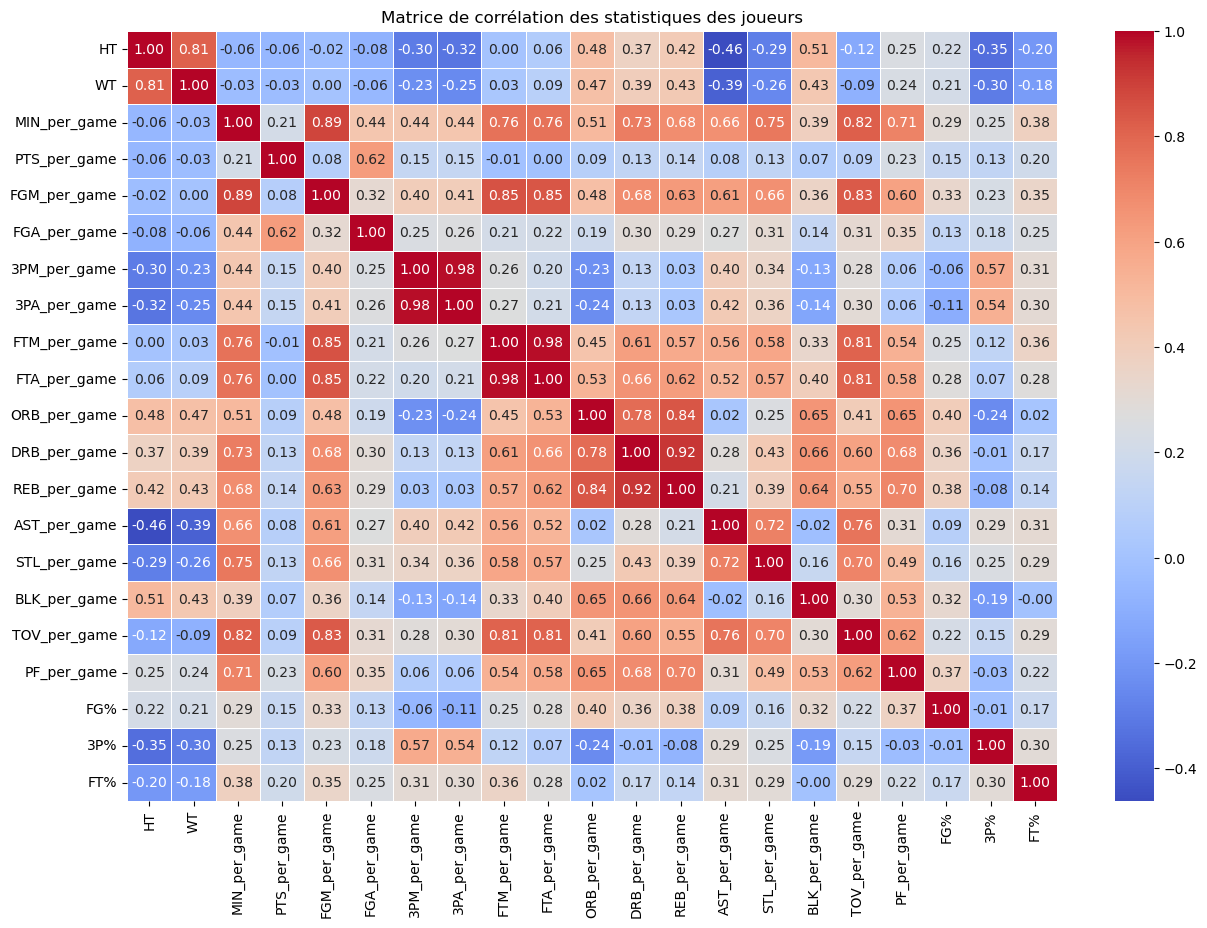

In [91]:
# Calcul de la matrice de corrélation
correlation_matrix = filtered_data.corr()

# Visualisation de la matrice de corrélation avec une heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matrice de corrélation des statistiques des joueurs')
plt.show()


#### Observation et conclusion

- HT (Height) et WT (Weight) :
    - Corrélation de 0.81, indiquant que les joueurs plus grands tendent également à être plus lourds.


- MIN_per_game (Minutes par match) :

    - Corrélé positivement avec plusieurs statistiques de jeu, notamment PTS_per_game (0.76), FGM_per_game (0.76), FGA_per_game (0.73), AST_per_game (0.61), STL_per_game (0.42), TOV_per_game (0.83).

    - Indique que les joueurs qui jouent plus de minutes tendent à marquer plus de points, faire plus de passes décisives, avoir plus de tentatives de tir, etc.


- PTS_per_game (Points par match) :

    - Très fortement corrélé avec FGM_per_game (0.85) et FGA_per_game (0.89).
    - Corrélé positivement avec 3PA_per_game (0.44) et FT_per_game (0.48).
    - Les joueurs qui marquent beaucoup de points tentent et réussissent généralement plus de tirs et de lancers francs.


- FGM_per_game (Field Goals Made par match) et FGA_per_game (Field Goals Attempted par match) :

    - Fortement corrélés entre eux (0.89).
    - Indique que les joueurs qui tentent plus de tirs réussissent également plus de tirs.


- 3PM_per_game (3-Points Made par match) et 3PA_per_game (3-Points Attempted par match) :

    - Très fortement corrélés entre eux (0.98).
    - Indique que les joueurs qui tentent plus de tirs à trois points réussissent également plus de tirs à trois points.


- ORB_per_game (Offensive Rebounds par match), DRB_per_game (Defensive Rebounds par match) et REB_per_game (Total Rebounds par match) :

    - ORB_per_game est fortement corrélé avec REB_per_game (0.78).

    - DRB_per_game est très fortement corrélé avec REB_per_game (0.97).
    
    - Indique que les rebonds offensifs et défensifs contribuent fortement au total des rebonds.


- AST_per_game (Assists par match) :

    - Corrélé positivement avec MIN_per_game (0.61), PTS_per_game (0.45), FGM_per_game (0.49), FGA_per_game (0.55).

    - Indique que les joueurs qui jouent plus de minutes et marquent plus de points tendent également à faire plus de passes décisives.


- STL_per_game (Steals par match) et BLK_per_game (Blocks par match) :

    - Corrélés positivement avec MIN_per_game (0.42 pour STL et 0.39 pour BLK).
    
    - Indique que les joueurs qui jouent plus de minutes ont tendance à réaliser plus de vols et de contres.


- TOV_per_game (Turnovers par match) :

    - Corrélé positivement avec MIN_per_game (0.83), PTS_per_game (0.66), FGA_per_game (0.83), AST_per_game (0.75).

    - Indique que les joueurs qui jouent plus de minutes et participent plus à l'attaque ont également plus de turnovers.


- FT_per_game (Free Throws Made par match) et FTA_per_game (Free Throws Attempted par match) :

    - Faible corrélation avec 3PM_per_game (0.34) et 3PA_per_game (0.13).

    - Indique que le pourcentage de réussite à trois points n'est pas directement proportionnel au nombre de tirs tentés ou réussis à trois points.


- Impact des caractéristiques physiques sur les performances de jeu

    - HT (Height) :

        - Corrélation modérée avec DRB_per_game (0.73), REB_per_game (0.66) et BLK_per_game (0.51).

        - Indique que les joueurs plus grands tendent à obtenir plus de rebonds défensifs et de contres.

    - WT (Weight) :

        - Corrélation modérée avec REB_per_game (0.57), DRB_per_game (0.73) et BLK_per_game (0.48).

        - Indique que les joueurs plus lourds tendent à obtenir plus de rebonds et de contres.




#### Conclusion générale sur la correlation des statistiques :

- Les minutes jouées, les points marqués, les tirs tentés et réussis, et les rebonds sont fortement corrélés. 

- Les caractéristiques physiques comme la taille et le poids ont également une corrélation modérée avec des statistiques défensives comme les rebonds et les contres. 

- Ces connaissances peuvent nous aider dans ce qui suit à mieux comprendre les facteurs clés qui influencent les performances des joueurs et pouvoir mieux comprendre les facteurs important à la victoire ou la défaite d'une équipe.

## PCA

In [34]:
all_cols = stats_cols + percentage_cols  # Statistiques de jeu par match et les statistiques de poucentage

# Filtrer les données pour inclure uniquement les colonnes pertinentes
filtered_data = merged_data[all_cols]

# Standardisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(filtered_data)

#### Application de la PCA

In [35]:
# Application de la PCA
nb_components = len(all_cols)
pca = PCA(n_components=nb_components)  # Garder toutes les composantes
X_pca = pca.fit_transform(X_scaled)

# Contribution de chaque composante principale
explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)

# Affichage des contributions
print("Contribution de chaque composante principale:")
for i, variance in enumerate(explained_variance, 1):
    print(f"Composante {i}: {variance:.4f}")

# Affichage des variances cumulées
print("\nVariance cumulée:")
for i, cumulative_variance in enumerate(cumulative_explained_variance, 1):
    print(f"Composante {i}: {cumulative_variance:.4f}")

Contribution de chaque composante principale:
Composante 1: 0.4336
Composante 2: 0.1794
Composante 3: 0.0875
Composante 4: 0.0575
Composante 5: 0.0487
Composante 6: 0.0365
Composante 7: 0.0292
Composante 8: 0.0271
Composante 9: 0.0214
Composante 10: 0.0184
Composante 11: 0.0175
Composante 12: 0.0148
Composante 13: 0.0078
Composante 14: 0.0071
Composante 15: 0.0058
Composante 16: 0.0035
Composante 17: 0.0029
Composante 18: 0.0007
Composante 19: 0.0005

Variance cumulée:
Composante 1: 0.4336
Composante 2: 0.6130
Composante 3: 0.7005
Composante 4: 0.7580
Composante 5: 0.8067
Composante 6: 0.8432
Composante 7: 0.8724
Composante 8: 0.8995
Composante 9: 0.9209
Composante 10: 0.9393
Composante 11: 0.9568
Composante 12: 0.9716
Composante 13: 0.9793
Composante 14: 0.9865
Composante 15: 0.9923
Composante 16: 0.9958
Composante 17: 0.9987
Composante 18: 0.9995
Composante 19: 1.0000


#### Contribution de chaque composante principale

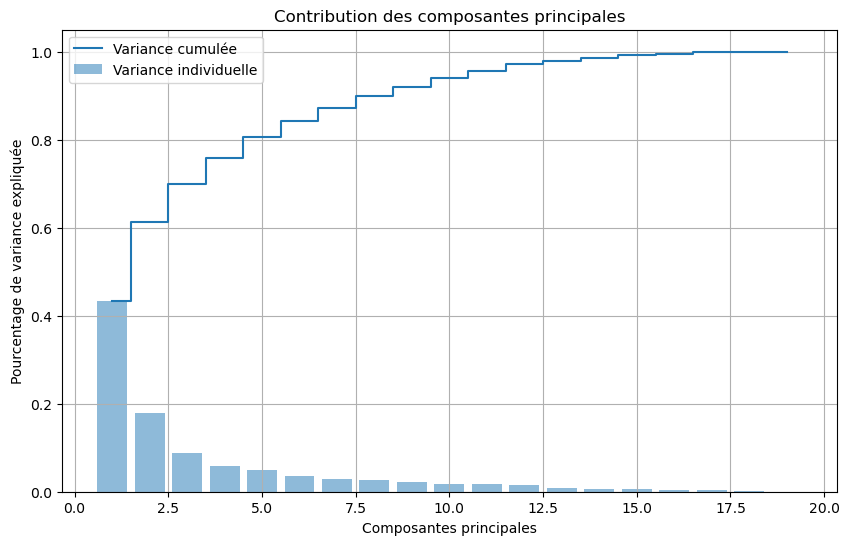

In [36]:
# Plot des contributions des composantes principales
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(all_cols) + 1), explained_variance, alpha=0.5, align='center', label='Variance individuelle')
plt.step(range(1, len(all_cols) + 1), cumulative_explained_variance, where='mid', label='Variance cumulée')
plt.ylabel('Pourcentage de variance expliquée')
plt.xlabel('Composantes principales')
plt.legend(loc='best')
plt.title('Contribution des composantes principales')
plt.grid(True)
plt.show()

#### On considère le nombre d'axe d'après le pourcentage de variance expliquée cumulée : On prend 80 % de variance cumulée donc 5 axes

#### Visualisation des scatter plots dans une grille

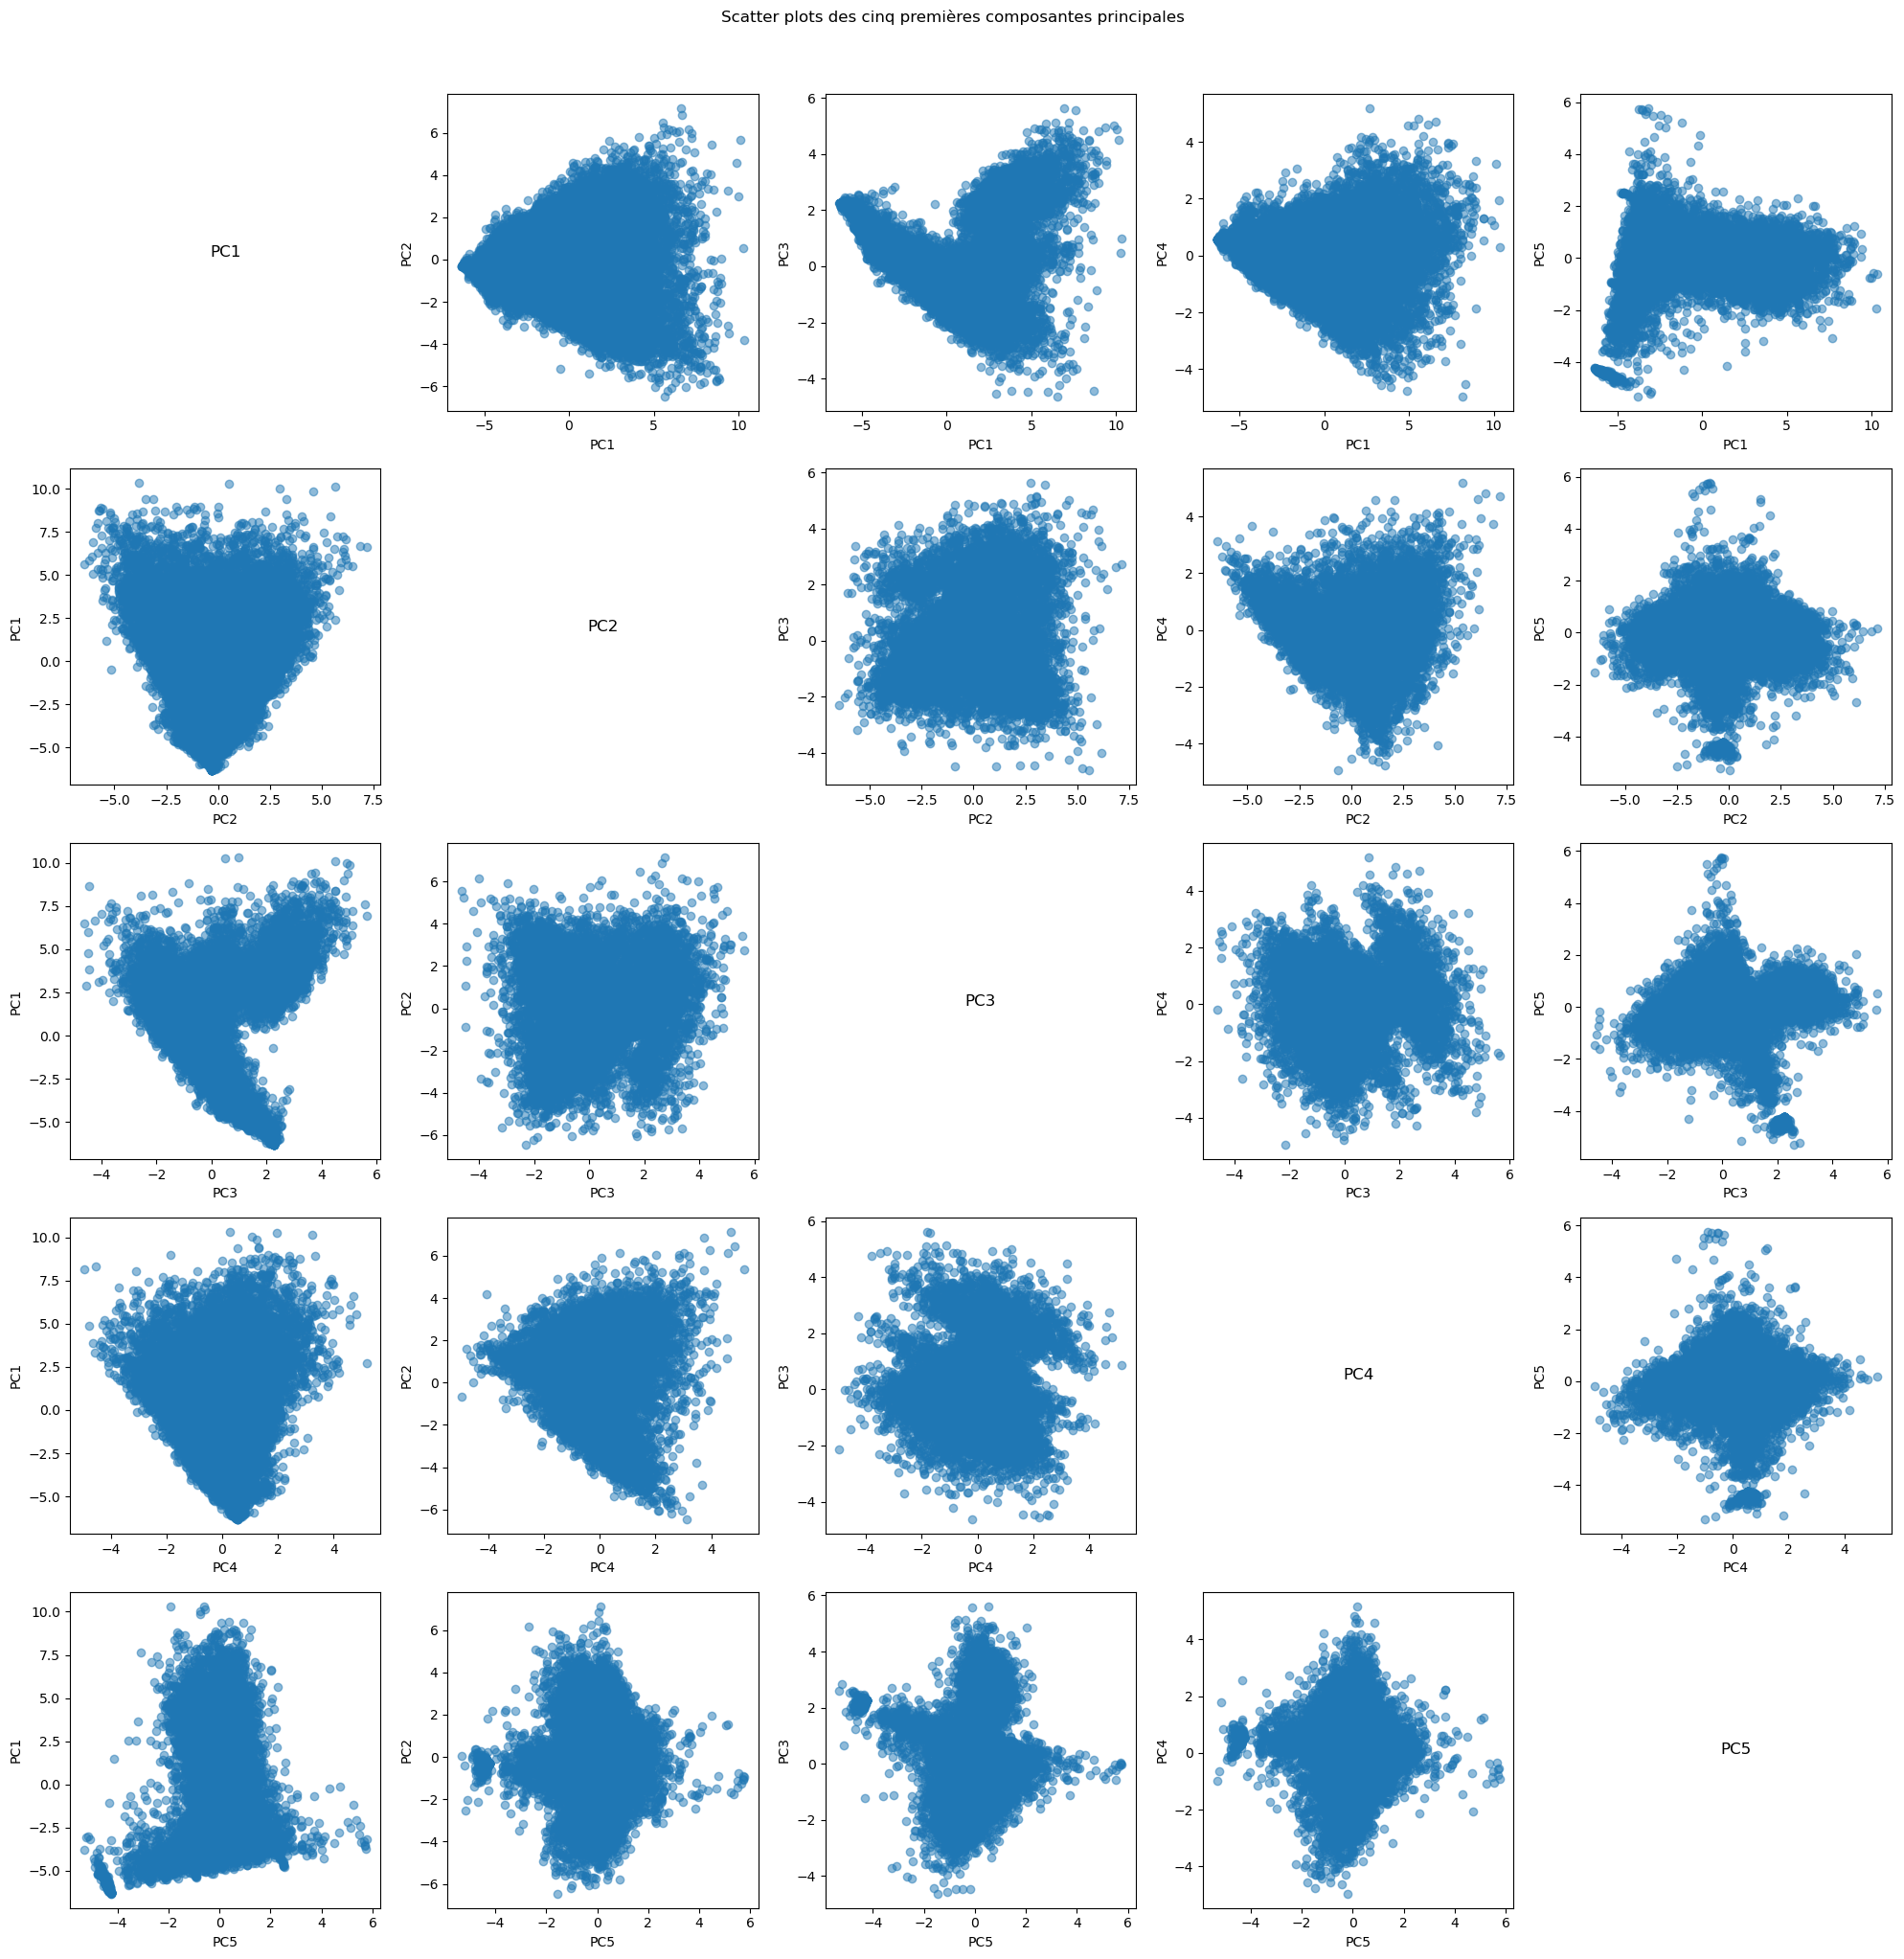

In [37]:
# Création d'une figure pour afficher les scatter plots
fig, axes = plt.subplots(5, 5, figsize=(20, 20))
fig.suptitle('Scatter plots des cinq premières composantes principales', y=1.02)

# Liste des étiquettes des composantes
labels = [f'PC{i+1}' for i in range(5)]

# Création des scatter plots pour chaque paire de composantes
for i in range(5):
    for j in range(5):
        if i != j:
            axes[i, j].scatter(X_pca[:, i], X_pca[:, j], alpha=0.5)
            axes[i, j].set_xlabel(labels[i])
            axes[i, j].set_ylabel(labels[j])
        else:
            axes[i, j].text(0.5, 0.5, labels[i], horizontalalignment='center', verticalalignment='center', fontsize=12)
            axes[i, j].set_axis_off()

# Ajustement des sous-plots pour une meilleure mise en page
plt.tight_layout()
plt.show()


#### Visualisation du cercle des corrélations

In [38]:
# Contribution des variables aux composantes principales
components = pca.components_

# Création d'un DataFrame pour les contributions
contributions = pd.DataFrame(components.T, columns=[f'PC{i+1}' for i in range(len(all_cols))], index=all_cols)

# Affichage des contributions
print(contributions)


                   PC1       PC2       PC3       PC4       PC5       PC6  \
MIN_per_game  0.330026  0.070013 -0.010978 -0.005260 -0.059554  0.034933   
PTS_per_game  0.072618  0.064825 -0.642332 -0.254401 -0.101585 -0.010860   
FGM_per_game  0.319774  0.058703  0.122354  0.024197  0.045448  0.017391   
FGA_per_game  0.152566  0.092904 -0.527955 -0.241986 -0.221246 -0.074873   
3PM_per_game  0.125615  0.420131 -0.077873  0.420466 -0.059397  0.033758   
3PA_per_game  0.126653  0.425100 -0.064827  0.394758 -0.105488  0.000914   
FTM_per_game  0.297586  0.014125  0.247016 -0.074679  0.075872 -0.215885   
FTA_per_game  0.300923 -0.037315  0.234569 -0.065817  0.033072 -0.163683   
ORB_per_game  0.215957 -0.360471 -0.072547  0.129529 -0.028979 -0.028987   
DRB_per_game  0.285535 -0.191370 -0.068055  0.265756 -0.075299 -0.042078   
REB_per_game  0.271342 -0.244143 -0.089367  0.224171 -0.064476 -0.043433   
AST_per_game  0.220537  0.242278  0.184750 -0.353512 -0.107105  0.226949   
STL_per_game

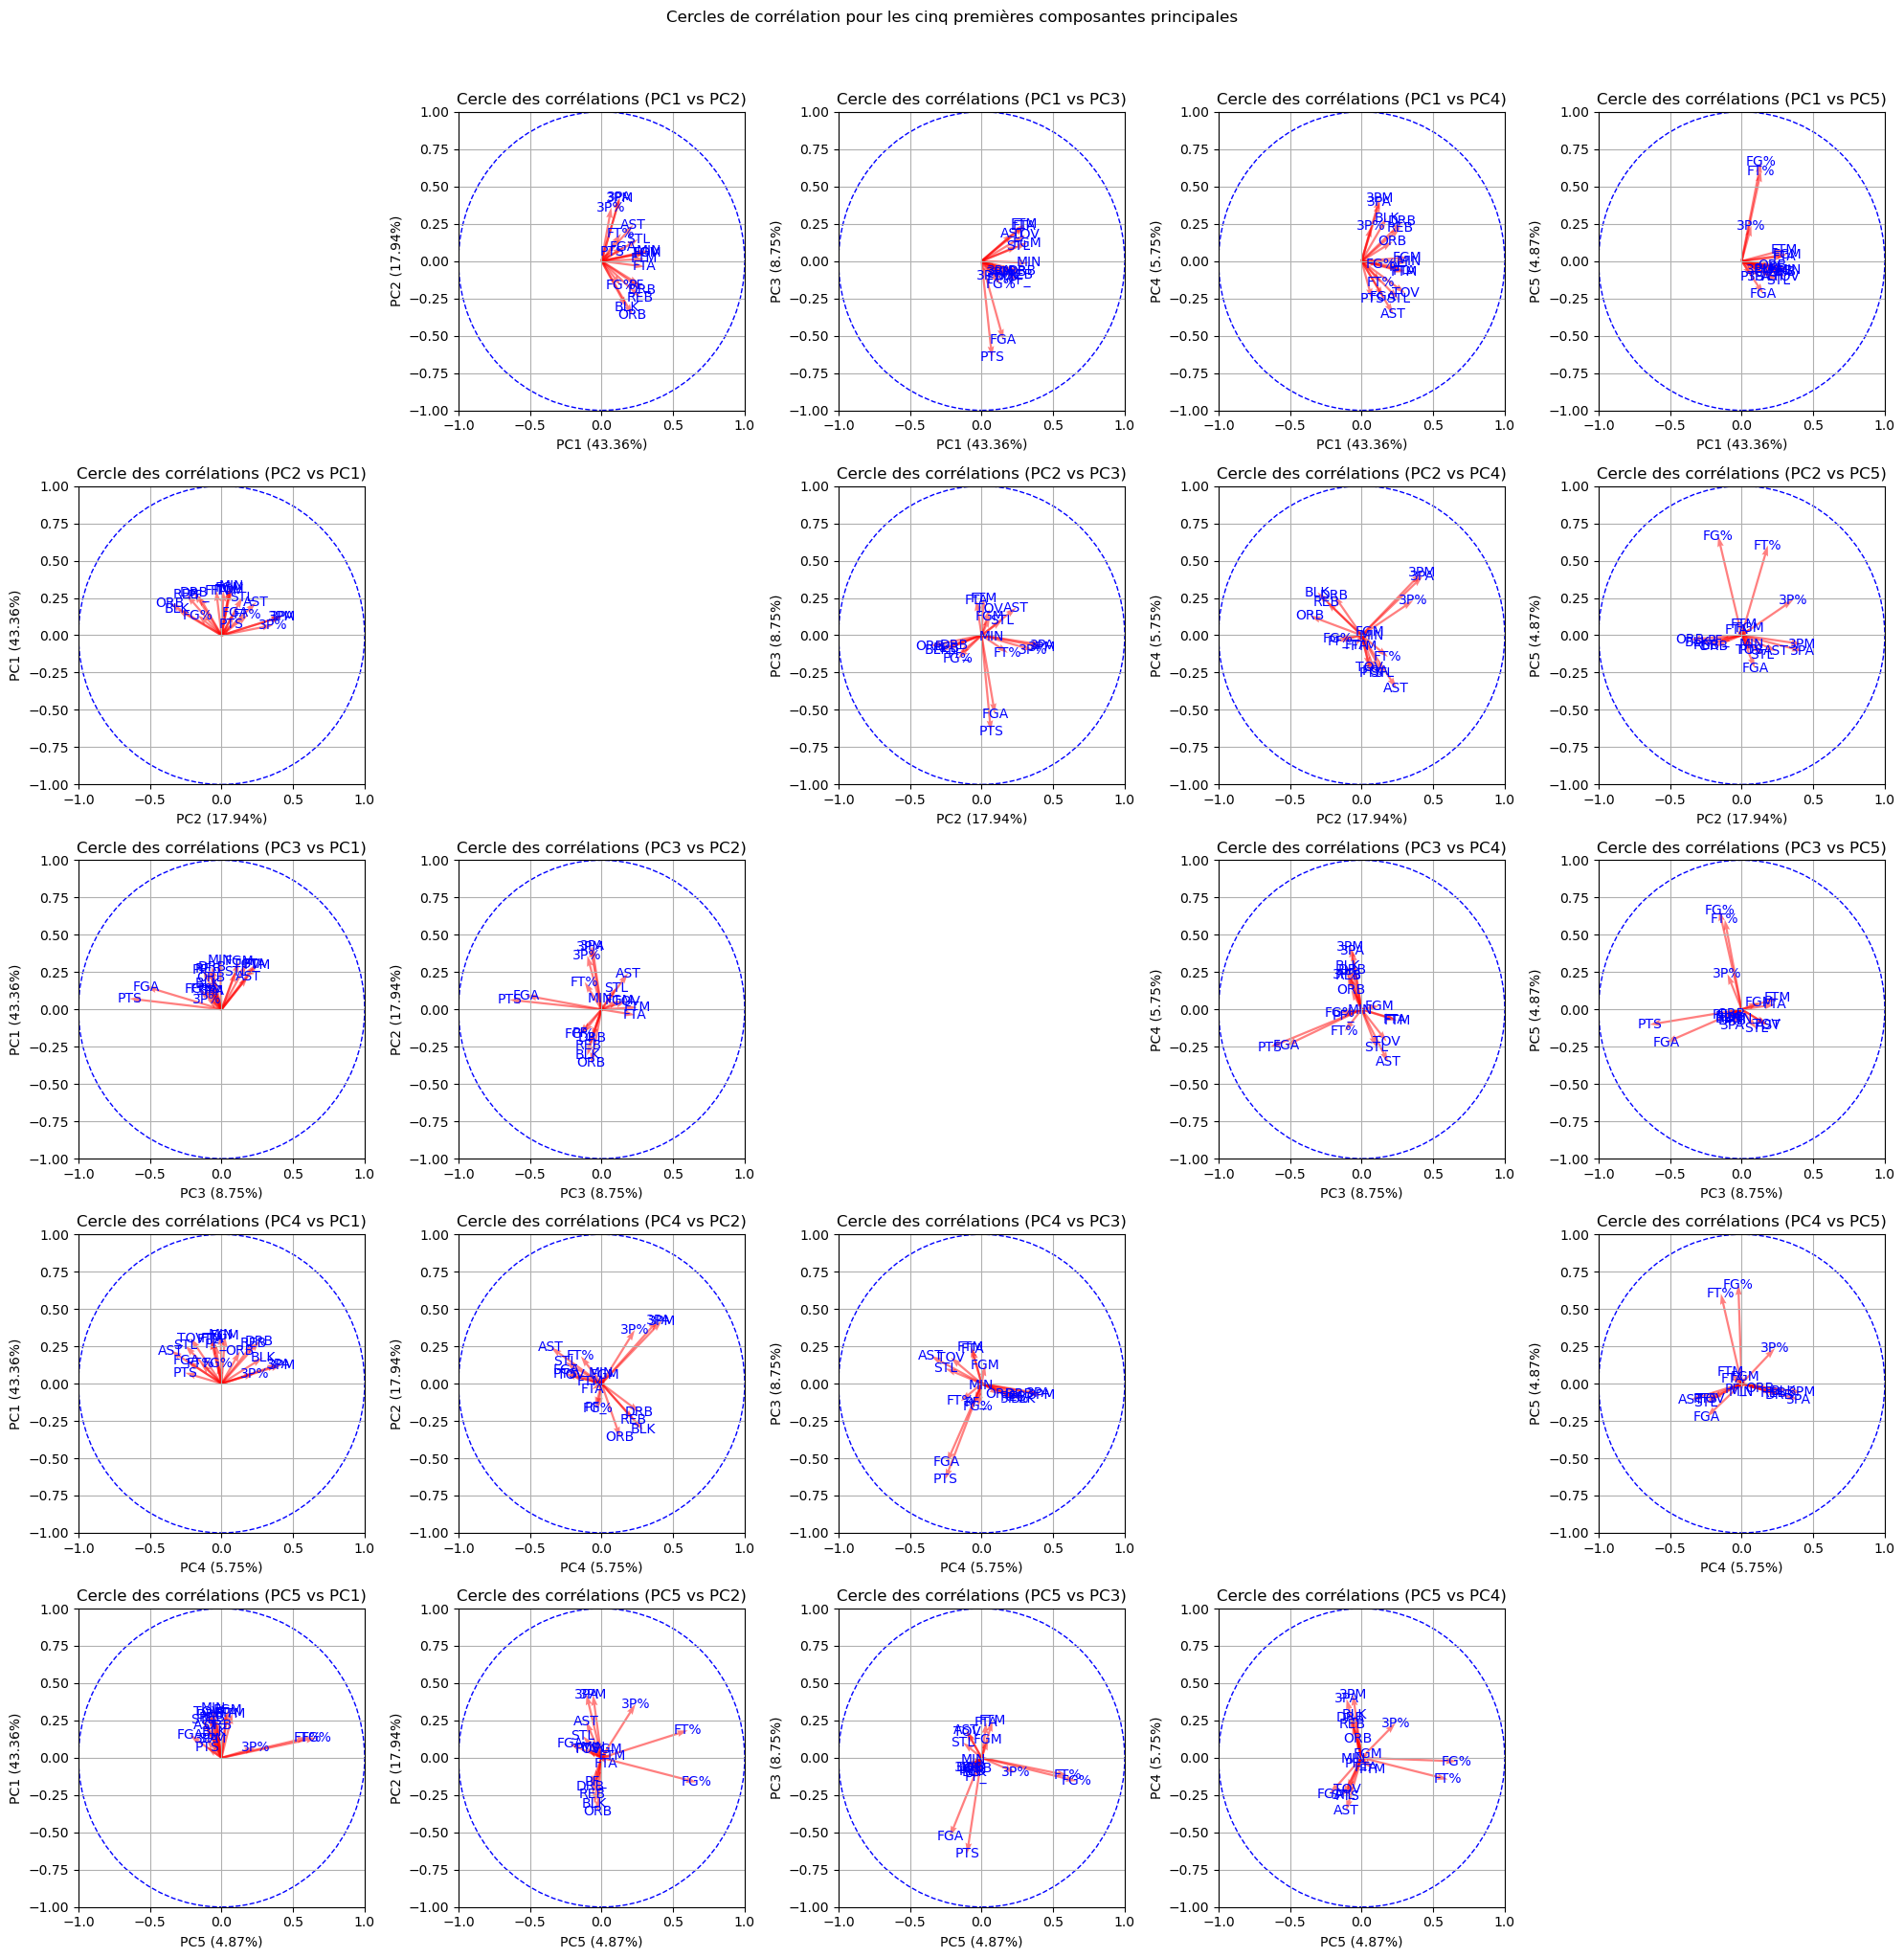

In [39]:
# Fonction pour afficher le cercle des corrélations
def plot_correlation_circle(ax, components, explained_variance, feature_names, pc1, pc2):
    ax.quiver(np.zeros(components.shape[1]), np.zeros(components.shape[1]), 
              components[pc1, :], components[pc2, :], 
              angles='xy', scale_units='xy', scale=1, color='r', alpha=0.5)
    for i, feature in enumerate(feature_names):
        ax.text(components[pc1, i], components[pc2, i], feature[:3], color='b', ha='center', va='center')

    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_xlabel(f'PC{pc1+1} ({explained_variance[pc1]*100:.2f}%)')
    ax.set_ylabel(f'PC{pc2+1} ({explained_variance[pc2]*100:.2f}%)')
    ax.set_title(f'Cercle des corrélations (PC{pc1+1} vs PC{pc2+1})')
    ax.grid()

    # Cercle
    circle = plt.Circle((0, 0), 1, facecolor='none', edgecolor='b', linestyle='--')
    ax.add_artist(circle)

# Affichage des cercles de corrélation pour toutes les paires des cinq premières composantes principales
fig, axes = plt.subplots(5, 5, figsize=(20, 20))
fig.suptitle('Cercles de corrélation pour les cinq premières composantes principales', y=1.02)

for i in range(5):
    for j in range(5):
        if i != j:
            plot_correlation_circle(axes[i, j], components, explained_variance, all_cols, i, j)
        else:
            axes[i, j].set_axis_off()

# Ajustement des sous-plots pour une meilleure mise en page
plt.tight_layout()
plt.show()


# Calculant les stats par rapport au positions (rôles) des joueurs et comparant les différentes positions :

Avant de commmencer l'analyse, voici un rappel sur les différents positions au basket : 

- C (Center) : Le pivot, souvent le joueur le plus grand et le plus fort physiquement, joue près du panier pour défendre et marquer.
- PF (Power Forward) : L'ailier fort, un joueur polyvalent qui combine taille et agilité, joue à mi-distance et près du panier.
- FC (Forward-Center) : Un joueur capable de jouer à la fois en position d'ailier fort et de pivot.
- PG (Point Guard) : Le meneur de jeu, responsable de diriger l'attaque, de distribuer le ballon et de créer des opportunités de tir.
- F (Forward) : Un terme général pour désigner un joueur jouant en position d'ailier, qui peut être soit ailier fort (PF) soit ailier (SF).
- SG (Shooting Guard) : L'arrière, un joueur souvent chargé de marquer des points à longue distance et de défendre contre les arrières adverses.
- G (Guard) : Un terme général pour désigner un joueur jouant en position de meneur (PG) ou d'arrière (SG).
- SF (Small Forward) : L'ailier, un joueur polyvalent et athlétique, capable de marquer de l'extérieur et de défendre plusieurs positions.
- GF (Guard-Forward) : Un joueur capable de jouer à la fois en position d'arrière et d'ailier.
- F-C (Forward-Center) : Similaire à FC, un joueur capable de jouer à la fois en position d'ailier fort et de pivot.
- G-F (Guard-Forward) : Similaire à GF, un joueur capable de jouer à la fois en position d'arrière et d'ailier.
- C-F (Center-Forward) : Un joueur capable de jouer en position de pivot et parfois en position d'ailier fort.
- F-G (Forward-Guard) : Similaire à GF et G-F, un joueur capable de jouer en position d'ailier et d'arrière.

#### Calcul des statistiques par position

In [149]:
# Exploser les listes de positions pour que chaque position apparaisse individuellement
exploded_data = merged_data.explode('Pos')

# Calcul des statistiques par position
position_stats = exploded_data.groupby('Pos')[all_cols].agg(['mean', 'var', 'std', 'min', 'max'])

# Affichage des statistiques par position
print("Statistiques par position:")
display(position_stats)

Statistiques par position:


HT                                              WT             \
         mean       var       std     min     max        mean        var   
Pos                                                                        
C    2.110022  0.001964  0.044319  1.9812  2.3114  111.684582  82.821314   
PF   2.052993  0.001597  0.039966  1.8542  2.1844  104.974265  67.144106   
PG   1.890269  0.003401  0.058316  1.6002  2.0574   85.386573  51.180001   
SF   2.015248  0.001567  0.039586  1.8542  2.1590   99.322487  56.779840   
SG   1.932226  0.003282  0.057287  1.6510  2.0574   89.497001  55.097310   

                                      ...       3P%                           \
          std        min         max  ...      mean       var       std  min   
Pos                                   ...                                      
C    9.100622  86.182550  161.025291  ...  0.101448  0.034576  0.185945  0.0   
PF   8.194151  79.378665  139.252858  ...  0.180701  0.036618  0.191359  0.0   
PG   7.154020  60.327785  115.666054  ...  0.291837  0.018697  0.136736  0.0   
SF   7.535240  78.471480  125.645086  ...  0.254147  0.027384  0.165481  0.0   
SG   7.422756  60.327785  113.398093  ...  0.290909  0.019734  0.140477  0.0   

               FT%                                
     max      mean       var       std  min  max  
Pos                                               
C    1.0  0.643208  0.035096  0.187339  0.0  1.0  
PF   1.0  0.675746  0.033623  0.183367  0.0  1.0  
PG   1.0  0.750149  0.034253  0.185075  0.0  1.0  
SF   1.0  0.702137  0.036883  0.192050  0.0  1.0  
SG   1.0  0.743823  0.033233  0.182299  0.0  1.0  

[5 rows x 105 columns]

#### Visualisation de la comparaison des statistiques entre les postes

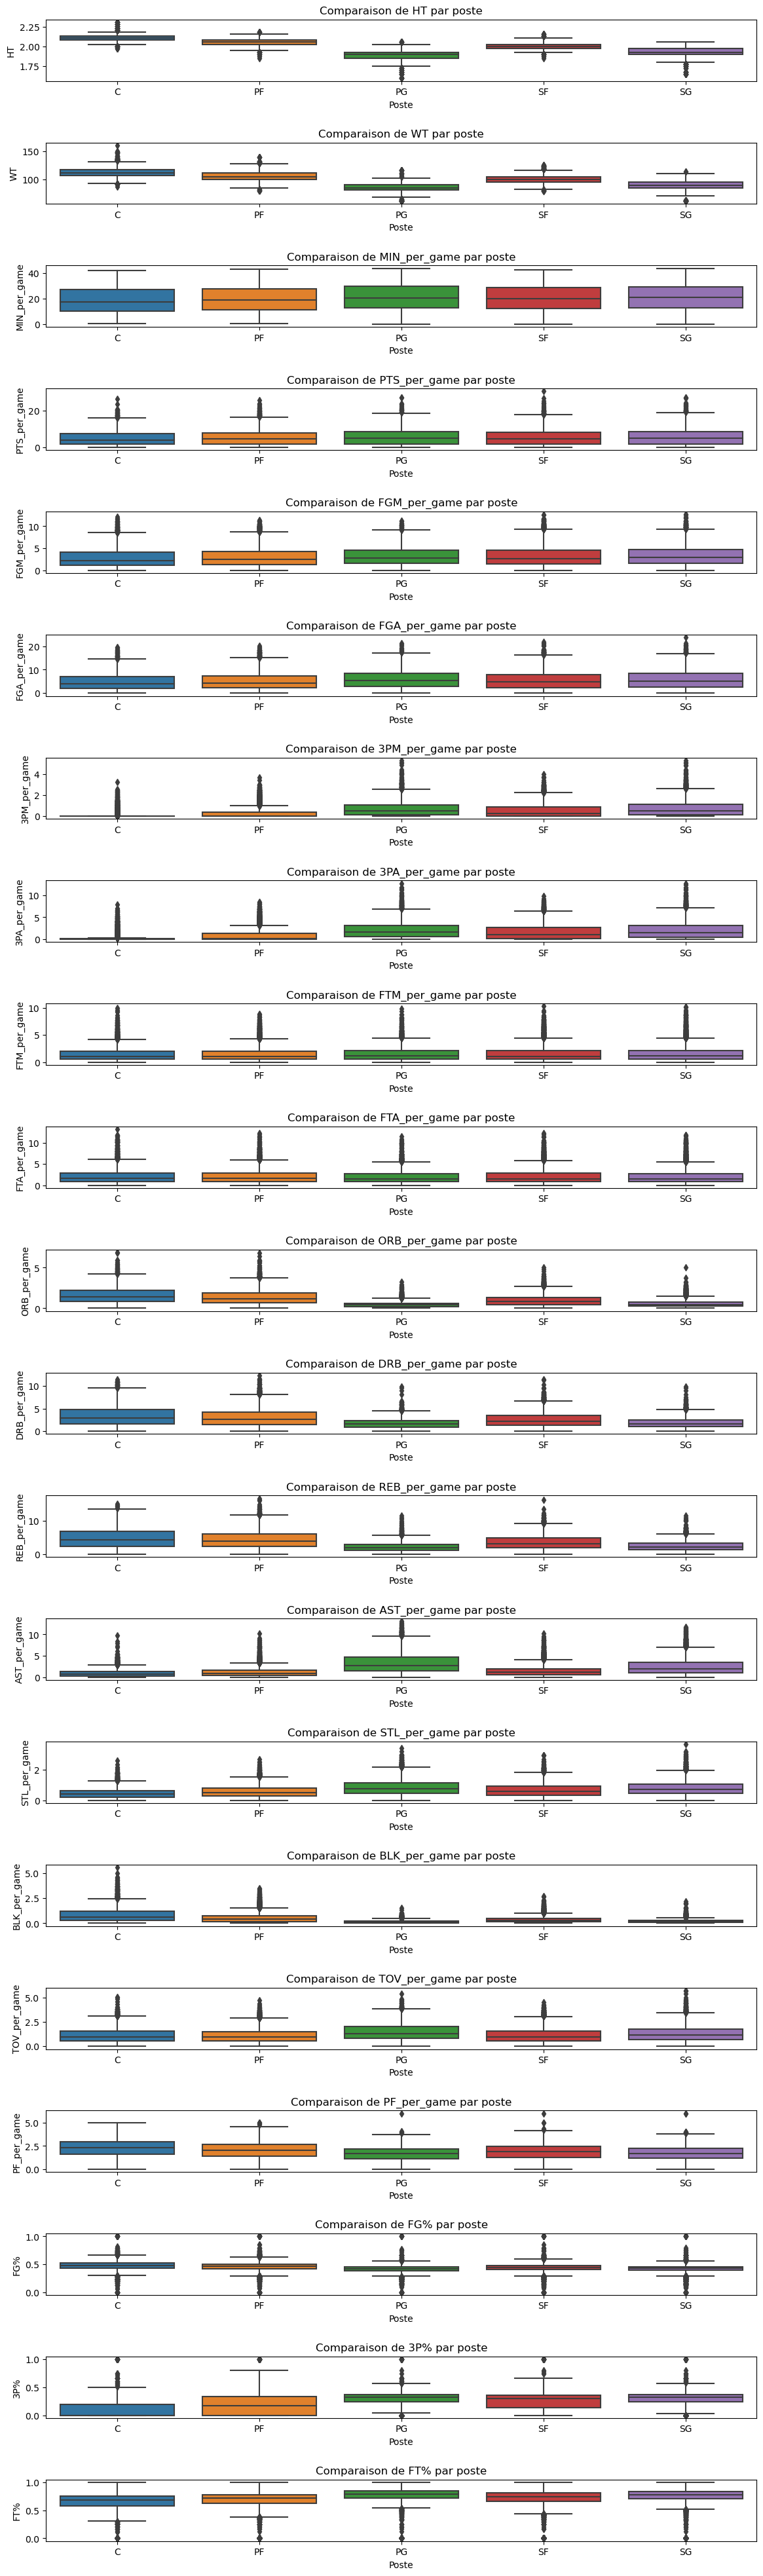

In [189]:
# Comparaison des moyennes des statistiques par poste
fig, axes = plt.subplots(len(all_cols), 1, figsize=(14, 50), gridspec_kw={'hspace': 1})

for i, col in enumerate(all_cols):
    sns.boxplot(data=exploded_data, x='Pos', y=col, ax=axes[i])
    axes[i].set_title(f'Comparaison de {col} par poste')
    axes[i].set_xlabel('Poste')
    axes[i].set_ylabel(col)



#### Comparaison de l'évolution des statistiques par poste

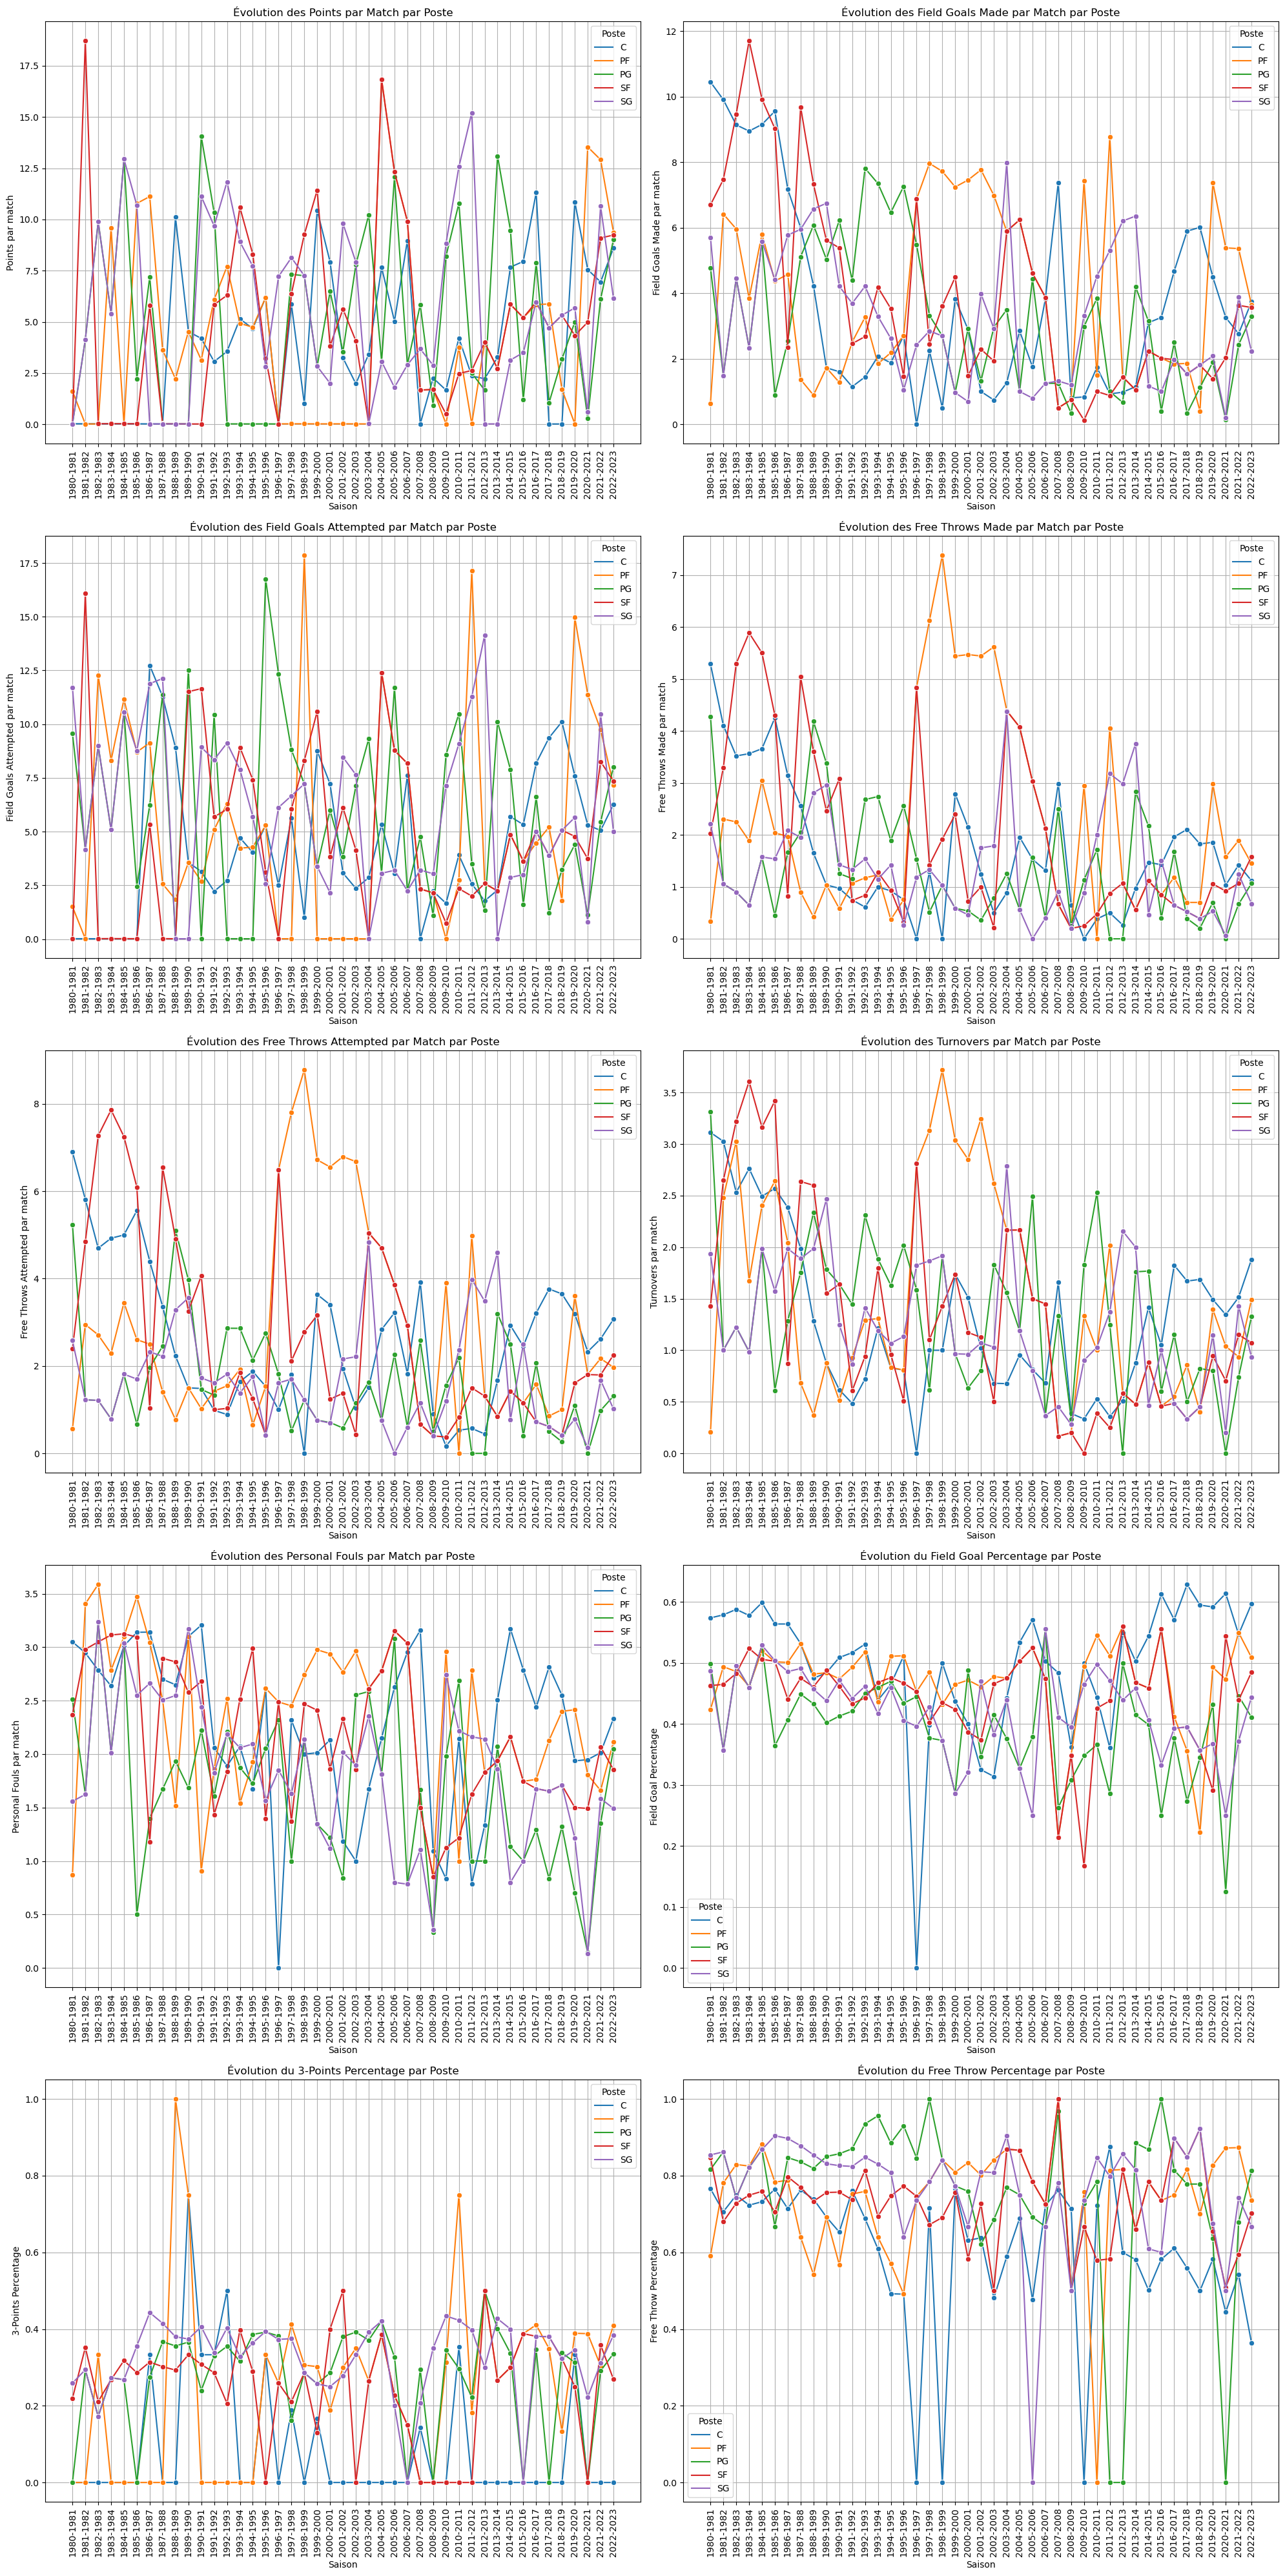

In [204]:
# Liste des statistiques à analyser
stats_to_plot = ['PTS_per_game', 'FGM_per_game', 'FGA_per_game', 
                 'FTM_per_game', 'FTA_per_game', 'TOV_per_game', 'PF_per_game', 
                 'FG%', '3P%', 'FT%']

# Créer des titres et des labels pour chaque statistique
titles = [
    'Évolution des Points par Match par Poste',
    'Évolution des Field Goals Made par Match par Poste',
    'Évolution des Field Goals Attempted par Match par Poste',
    'Évolution des Free Throws Made par Match par Poste',
    'Évolution des Free Throws Attempted par Match par Poste',
    'Évolution des Turnovers par Match par Poste',
    'Évolution des Personal Fouls par Match par Poste',
    'Évolution du Field Goal Percentage par Poste',
    'Évolution du 3-Points Percentage par Poste',
    'Évolution du Free Throw Percentage par Poste'
]

ylabels = [
    'Points par match',
    'Field Goals Made par match',
    'Field Goals Attempted par match',
    'Free Throws Made par match',
    'Free Throws Attempted par match',
    'Turnovers par match',
    'Personal Fouls par match',
    'Field Goal Percentage',
    '3-Points Percentage',
    'Free Throw Percentage'
]

# Définir la taille de la grille
n_cols = 2
n_rows = (len(stats_to_plot) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 40))
axes = axes.flatten()

# Tracer les graphiques d'évolution pour chaque statistique
for i, (stat, title, ylabel) in enumerate(zip(stats_to_plot, titles, ylabels)):
    sns.lineplot(data=exploded_data, x='Season', y=stat, hue='Pos', marker='o', ax=axes[i])
    axes[i].set_title(title)
    axes[i].set_xlabel('Saison')
    axes[i].set_ylabel(ylabel)
    axes[i].tick_params(axis='x', rotation=90)
    axes[i].legend(title='Poste')
    axes[i].grid(True)

# Supprimer les axes vides si le nombre de statistiques n'est pas un multiple de n_cols
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


### Analyse et observations

Les box plots fournis montrent la distribution des différentes statistiques des joueurs de NBA par poste. Voici une analyse détaillée de chaque statistique :

#### Caractéristiques Physiques

1. **HT (Height)** :
   - Les **Centers (C)** sont les plus grands, avec une médiane autour de 2.1 mètres.
   - Les **Power Forwards (PF)** ont une médiane légèrement inférieure, autour de 2.0 mètres.
   - Les **Point Guards (PG)**, **Small Forwards (SF)** et **Shooting Guards (SG)** sont plus petits, avec des médianes autour de 1.95 et 1.90 mètres respectivement.

2. **WT (Weight)** :
   - Les **Centers (C)** sont les plus lourds, avec une médiane autour de 115 kg.
   - Les **Power Forwards (PF)** ont une médiane légèrement inférieure, autour de 105 kg.
   - Les **Point Guards (PG)**, **Small Forwards (SF)** et **Shooting Guards (SG)** sont plus légers, avec des médianes autour de 95 et 85 kg respectivement.

#### Statistiques de Jeu

3. **MIN_per_game (Minutes par match)**, **PTS_per_game (Points par match)**, **FGM_per_game (Field Goals Made par match)**, **FGA_per_game (Field Goals Attempted par match)**, **FTM_per_game (Free Throws Made par match)**, **FTA_per_game (Free Throws Attempted par match)**, **TOV_per_game (Turnovers par match)**, **PF_per_game (Personal Fouls par match)**, **FG% (Field Goal Percentage)**, **3P% (3-Points Percentage)**, **FT% (Free Throw Percentage)** :
   - Ces statistiques sont à peu près équivalentes pour tous les postes.

4. **3PM_per_game (3-Points Made par match)** et **3PA_per_game (3-Points Attempted par match)** :
   - Les **Shooting Guards (SG)** sont les plus actifs en termes de tentatives et réussites de tirs à trois points.
   - Les **Centers (C)** et **Power Forwards (PF)** ont moins de tentatives et réussites à trois points.

5. **ORB_per_game (Offensive Rebounds par match)** et **DRB_per_game (Defensive Rebounds par match)** :
   - Les **Centers (C)** et **Power Forwards (PF)** dominent en termes de rebonds offensifs et défensifs.
   - Les **Small Forwards (SF)** et **Shooting Guards (SG)** ont des valeurs plus faibles.

6. **REB_per_game (Total Rebounds par match)** :
   - Les **Centers (C)** et **Power Forwards (PF)** ont le plus grand nombre total de rebonds.
   - Les **Small Forwards (SF)** et **Shooting Guards (SG)** ont des valeurs plus faibles.

7. **AST_per_game (Assists par match)** :
   - Les **Point Guards (PG)** et **Shooting Guards (SG)** ont le plus grand nombre de passes décisives.
   - Les **Centers (C)** et **Power Forwards (PF)** ont des valeurs plus faibles.

8. **STL_per_game (Steals par match)** et **BLK_per_game (Blocks par match)** :
   - Les **Shooting Guards (SG)** ont plus d'interceptions (steals).
   - Les **Centers (C)** et **Power Forwards (PF)** ont plus de contres (blocks).

#### Conclusion Générale

- **Centers (C) et Power Forwards (PF)** :
  - Sont généralement les plus grands et les plus lourds.
  - Excellents en rebonds et en contres, mais moins impliqués dans les tirs à trois points et les passes décisives.
  - Ont un pourcentage de réussite aux tirs plus élevé.

- **Shooting Guards (SG) et Small Forwards (SF)** :
  - Sont les plus actifs en termes de tentatives et réussites de tirs à trois points.
  - Ont un nombre élevé d'interceptions (steals) et de passes décisives.
  - Ont un pourcentage de réussite aux tirs à trois points plus élevé.

- **Point Guards (PG)** :
  - Excellents en passes décisives et minutes jouées.
  - Partagent des similitudes avec les Shooting Guards (SG) pour certaines statistiques, mais ont moins de rebonds et de contres.

- **Statistiques Relativement Homogènes entre les Postes** :
  - Certaines statistiques comme les minutes jouées (MIN_per_game), les points (PTS_per_game), les tirs réussis (FGM_per_game), les tirs tentés (FGA_per_game), les lancers francs réussis (FTM_per_game), les lancers francs tentés (FTA_per_game), les turnovers (TOV_per_game), les fautes personnelles (PF_per_game), et les pourcentages de réussite (FG%, 3P%, FT%) montrent des variations très faibles entre les différents postes.


# Analyse des clusters 

## Calculer le nombre de clusters optimal 

In [213]:
# Standardisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(exploded_data[all_cols])

# Réduction de dimensionnalité avec PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

#### Méthode du coude

c:\Users\Kadem\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Kadem\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Kadem\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Kadem\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Window

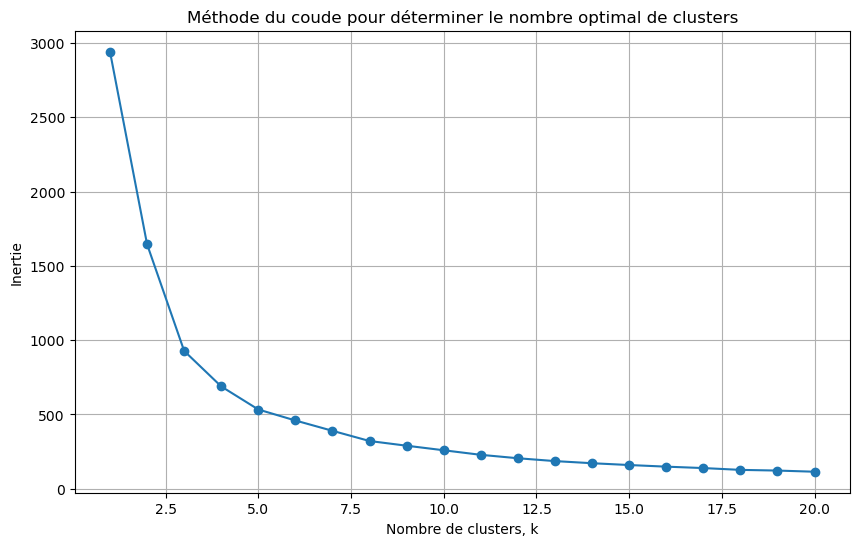

In [215]:
import os
# Définir OMP_NUM_THREADS à 1
os.environ['OMP_NUM_THREADS'] = '1'

# Méthode du coude pour déterminer le nombre optimal de clusters
inertia = []
k_range = range(1, 21)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

# Plot de la méthode du coude
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Nombre de clusters, k')
plt.ylabel('Inertie')
plt.title('Méthode du coude pour déterminer le nombre optimal de clusters')
plt.grid(True)
plt.show()


#### Indice de silhouette

c:\Users\Kadem\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Kadem\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Kadem\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Kadem\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Window

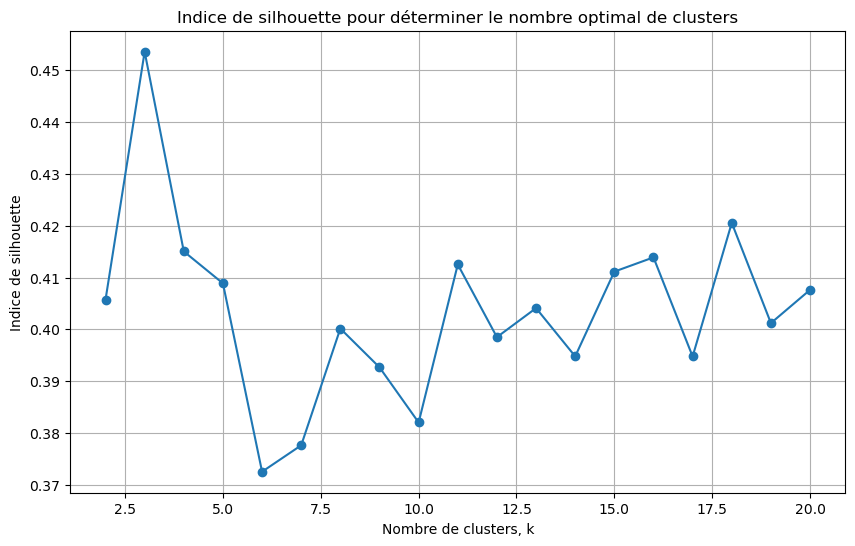

In [216]:
# Indice de silhouette pour déterminer le nombre optimal de clusters
silhouette_scores = []
k_range = range(2, 21)  # Commencer à 2 pour éviter l'erreur
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_pca)
    score = silhouette_score(X_pca, kmeans.labels_)
    silhouette_scores.append(score)

# Plot de l'indice de silhouette
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel('Nombre de clusters, k')
plt.ylabel('Indice de silhouette')
plt.title('Indice de silhouette pour déterminer le nombre optimal de clusters')
plt.grid(True)
plt.show()


#### interprétation des méthodes et choix du nombre de clusters

- Méthode du coude : Il faut chercher le point où l'inertie cesse de diminuer de manière significative : dans notre cas approximativement 11


- Indice de silhouette : Il faut chercher le nombre de clusters qui maximise l'indice de silhouette. Un score plus élevé indique des clusters bien séparés et compacts : dans notre cas 3 semble être l'idéal, 11 est plutôt acceptable aussi.

On choisit donc le nombre de clusters = 11

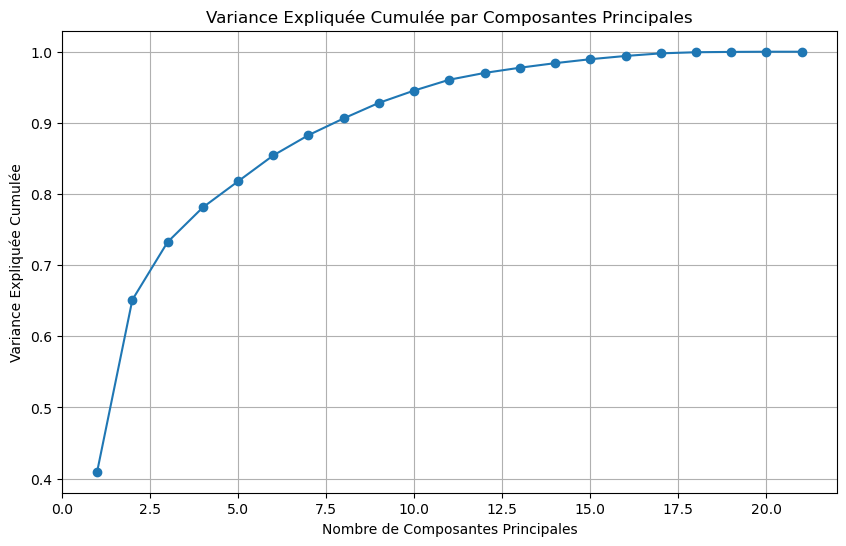

In [229]:
# Préparer les données pour le clustering
data_for_clustering = exploded_data[all_cols].dropna()
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_for_clustering)

# Appliquer PCA
pca = PCA()
data_pca = pca.fit_transform(data_scaled)

# Variance expliquée par chaque composante principale
explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)

# Tracer la courbe de la variance expliquée cumulée
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o')
plt.title('Variance Expliquée Cumulée par Composantes Principales')
plt.xlabel('Nombre de Composantes Principales')
plt.ylabel('Variance Expliquée Cumulée')
plt.grid(True)
plt.show()

On choisit 7 axes pour avoir une var de 90 %

#### Visualiser les clusters avec PCA

c:\Users\Kadem\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Kadem\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


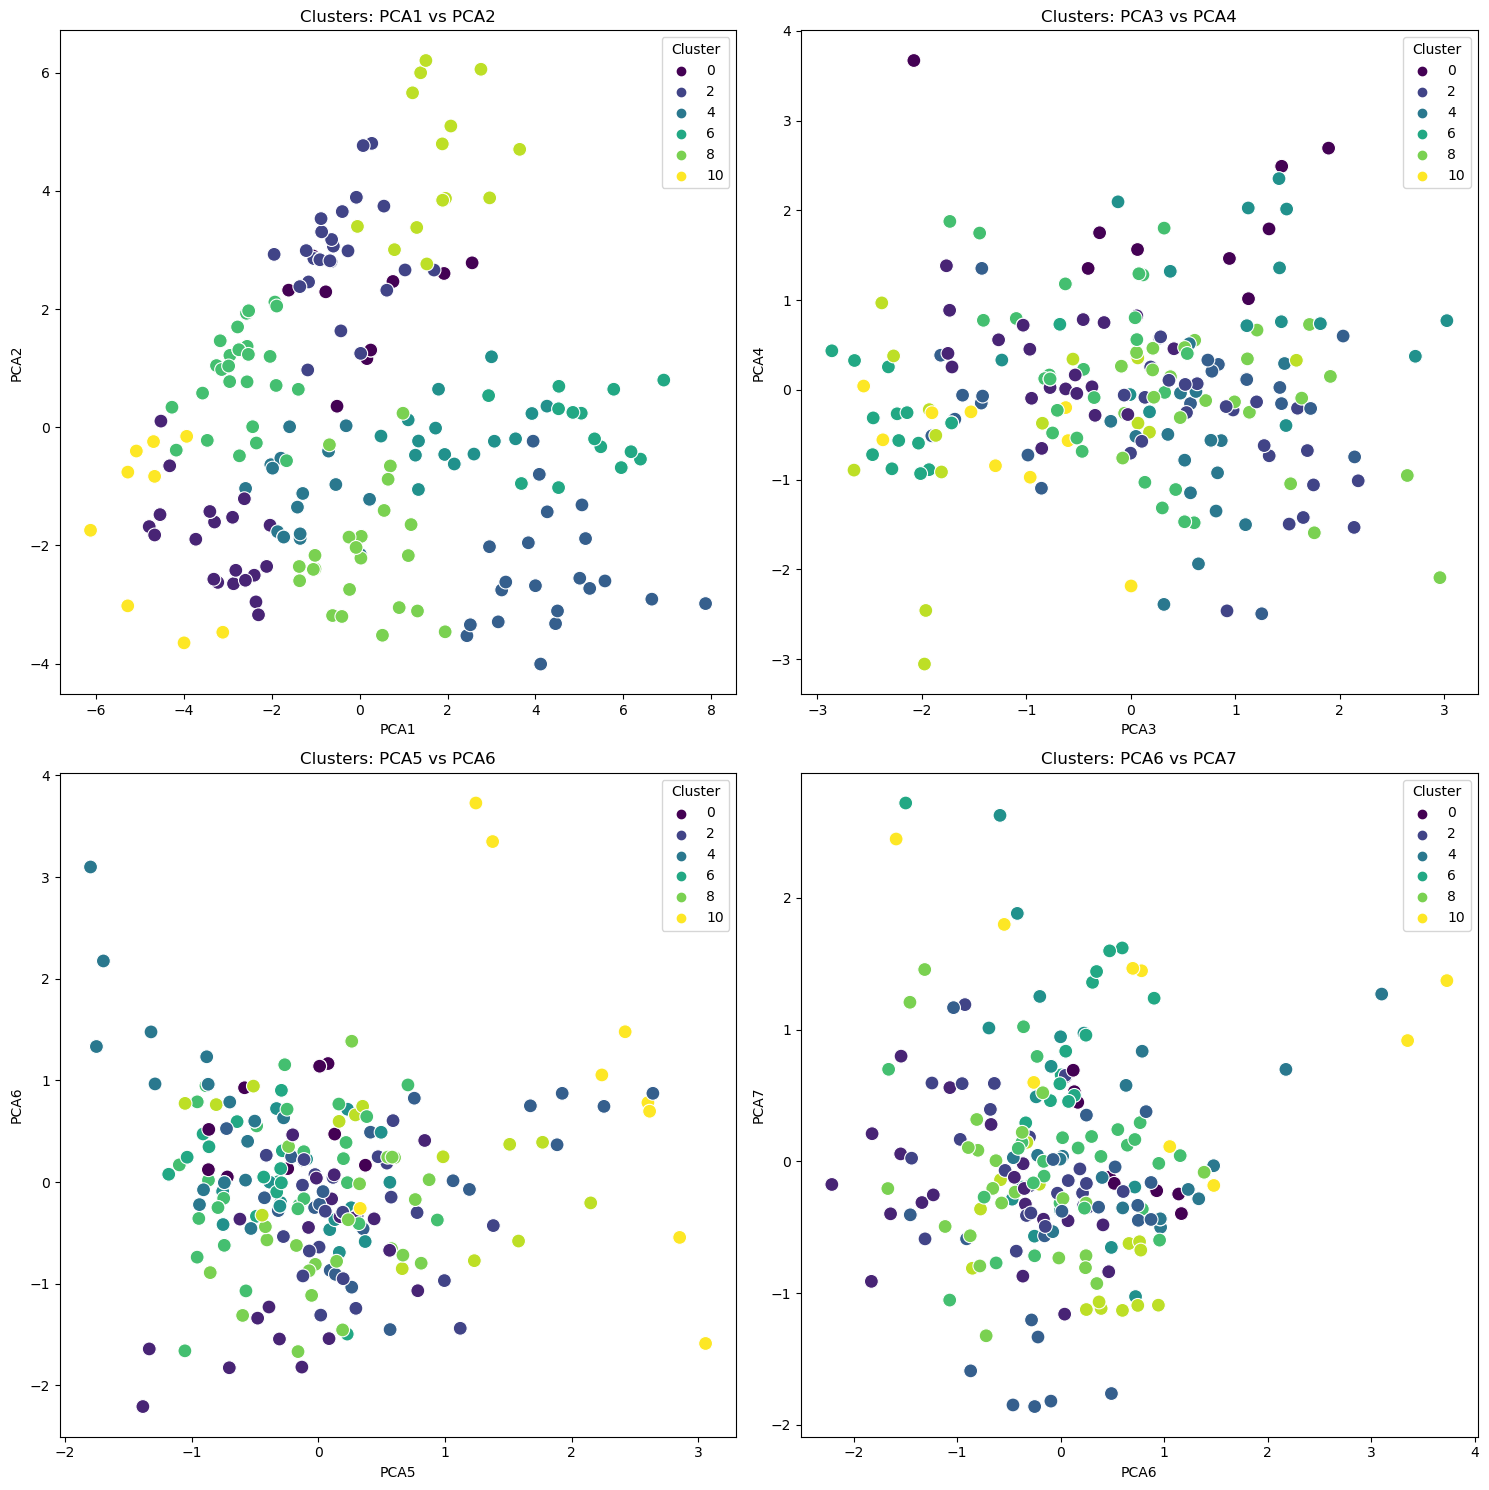

In [233]:
# Préparer les données pour le clustering
data_for_clustering = exploded_data[all_cols].dropna()
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_for_clustering)

# Appliquer PCA avec 7 composantes principales
pca = PCA(n_components=7)
data_pca = pca.fit_transform(data_scaled)

# Appliquer KMeans
n_clusters = 11
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(data_pca)

# Ajouter les clusters et les composantes principales PCA au DataFrame pour visualisation
exploded_data['Cluster'] = clusters
for i in range(7):
    exploded_data[f'PCA{i+1}'] = data_pca[:, i]

# Visualiser les clusters par rapport aux axes PCA
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
axes = axes.flatten()

sns.scatterplot(data=exploded_data, x='PCA1', y='PCA2', hue='Cluster', palette='viridis', s=100, ax=axes[0])
axes[0].set_title('Clusters: PCA1 vs PCA2')
axes[0].set_xlabel('PCA1')
axes[0].set_ylabel('PCA2')

sns.scatterplot(data=exploded_data, x='PCA3', y='PCA4', hue='Cluster', palette='viridis', s=100, ax=axes[1])
axes[1].set_title('Clusters: PCA3 vs PCA4')
axes[1].set_xlabel('PCA3')
axes[1].set_ylabel('PCA4')

sns.scatterplot(data=exploded_data, x='PCA5', y='PCA6', hue='Cluster', palette='viridis', s=100, ax=axes[2])
axes[2].set_title('Clusters: PCA5 vs PCA6')
axes[2].set_xlabel('PCA5')
axes[2].set_ylabel('PCA6')

sns.scatterplot(data=exploded_data, x='PCA6', y='PCA7', hue='Cluster', palette='viridis', s=100, ax=axes[3])
axes[3].set_title('Clusters: PCA6 vs PCA7')
axes[3].set_xlabel('PCA6')
axes[3].set_ylabel('PCA7')

plt.tight_layout()
plt.show()

#### Appliquer t-SNE et visualiser les clusters

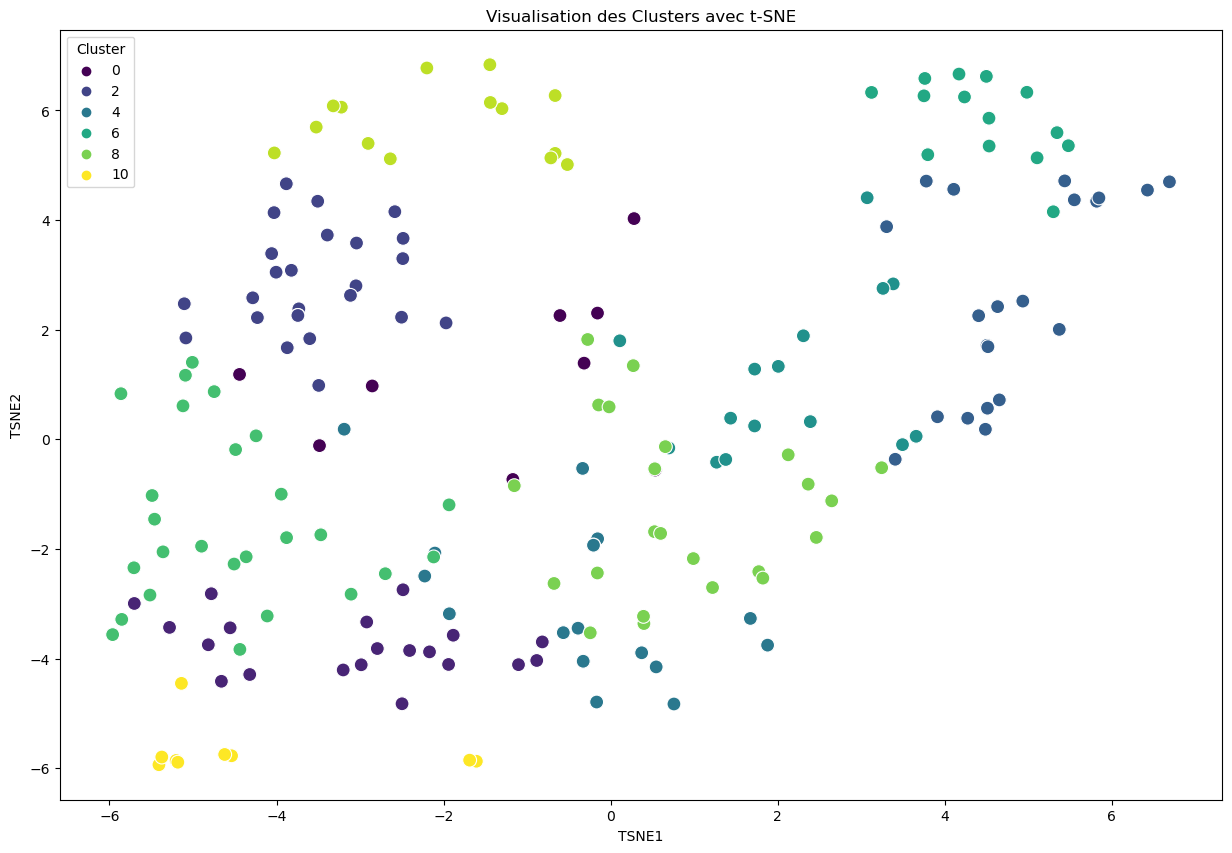

In [255]:
from sklearn.manifold import TSNE

# Appliquer t-SNE
tsne = TSNE(n_components=3, random_state=42)
data_tsne = tsne.fit_transform(data_scaled)

# Ajouter les résultats t-SNE au DataFrame pour visualisation
exploded_data['TSNE1'] = data_tsne[:, 0]
exploded_data['TSNE2'] = data_tsne[:, 1]

# Visualiser les clusters avec t-SNE
plt.figure(figsize=(15, 10))
sns.scatterplot(data=exploded_data, x='TSNE1', y='TSNE2', hue='Cluster', palette='viridis', s=100)
plt.title('Visualisation des Clusters avec t-SNE')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.legend(title='Cluster')
plt.show()


#### Cercles de Corrélations avec les Positions

<Figure size 1400x700 with 0 Axes>

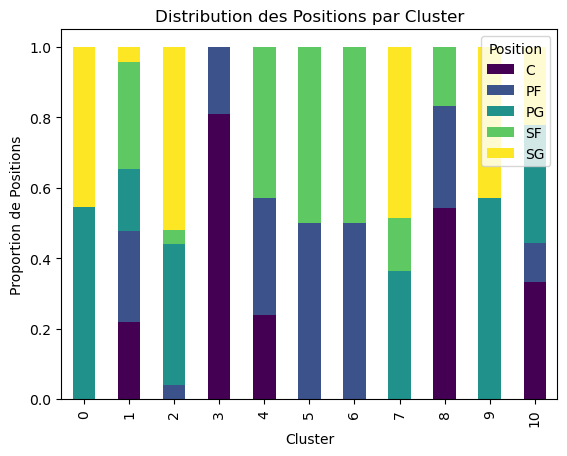

In [245]:
# Distribution des positions au sein de chaque cluster
position_cluster_dist = exploded_data.groupby(['Cluster', 'Pos']).size().unstack(fill_value=0)

# Normalisation pour obtenir les proportions
position_cluster_dist_norm = position_cluster_dist.div(position_cluster_dist.sum(axis=1), axis=0)

# Visualisation de la distribution des positions pour chaque cluster
plt.figure(figsize=(14, 7))
position_cluster_dist_norm.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Distribution des Positions par Cluster')
plt.xlabel('Cluster')
plt.ylabel('Proportion de Positions')
plt.legend(title='Position')
plt.show()


#### Distribution des Positions par Rapport aux Clusters

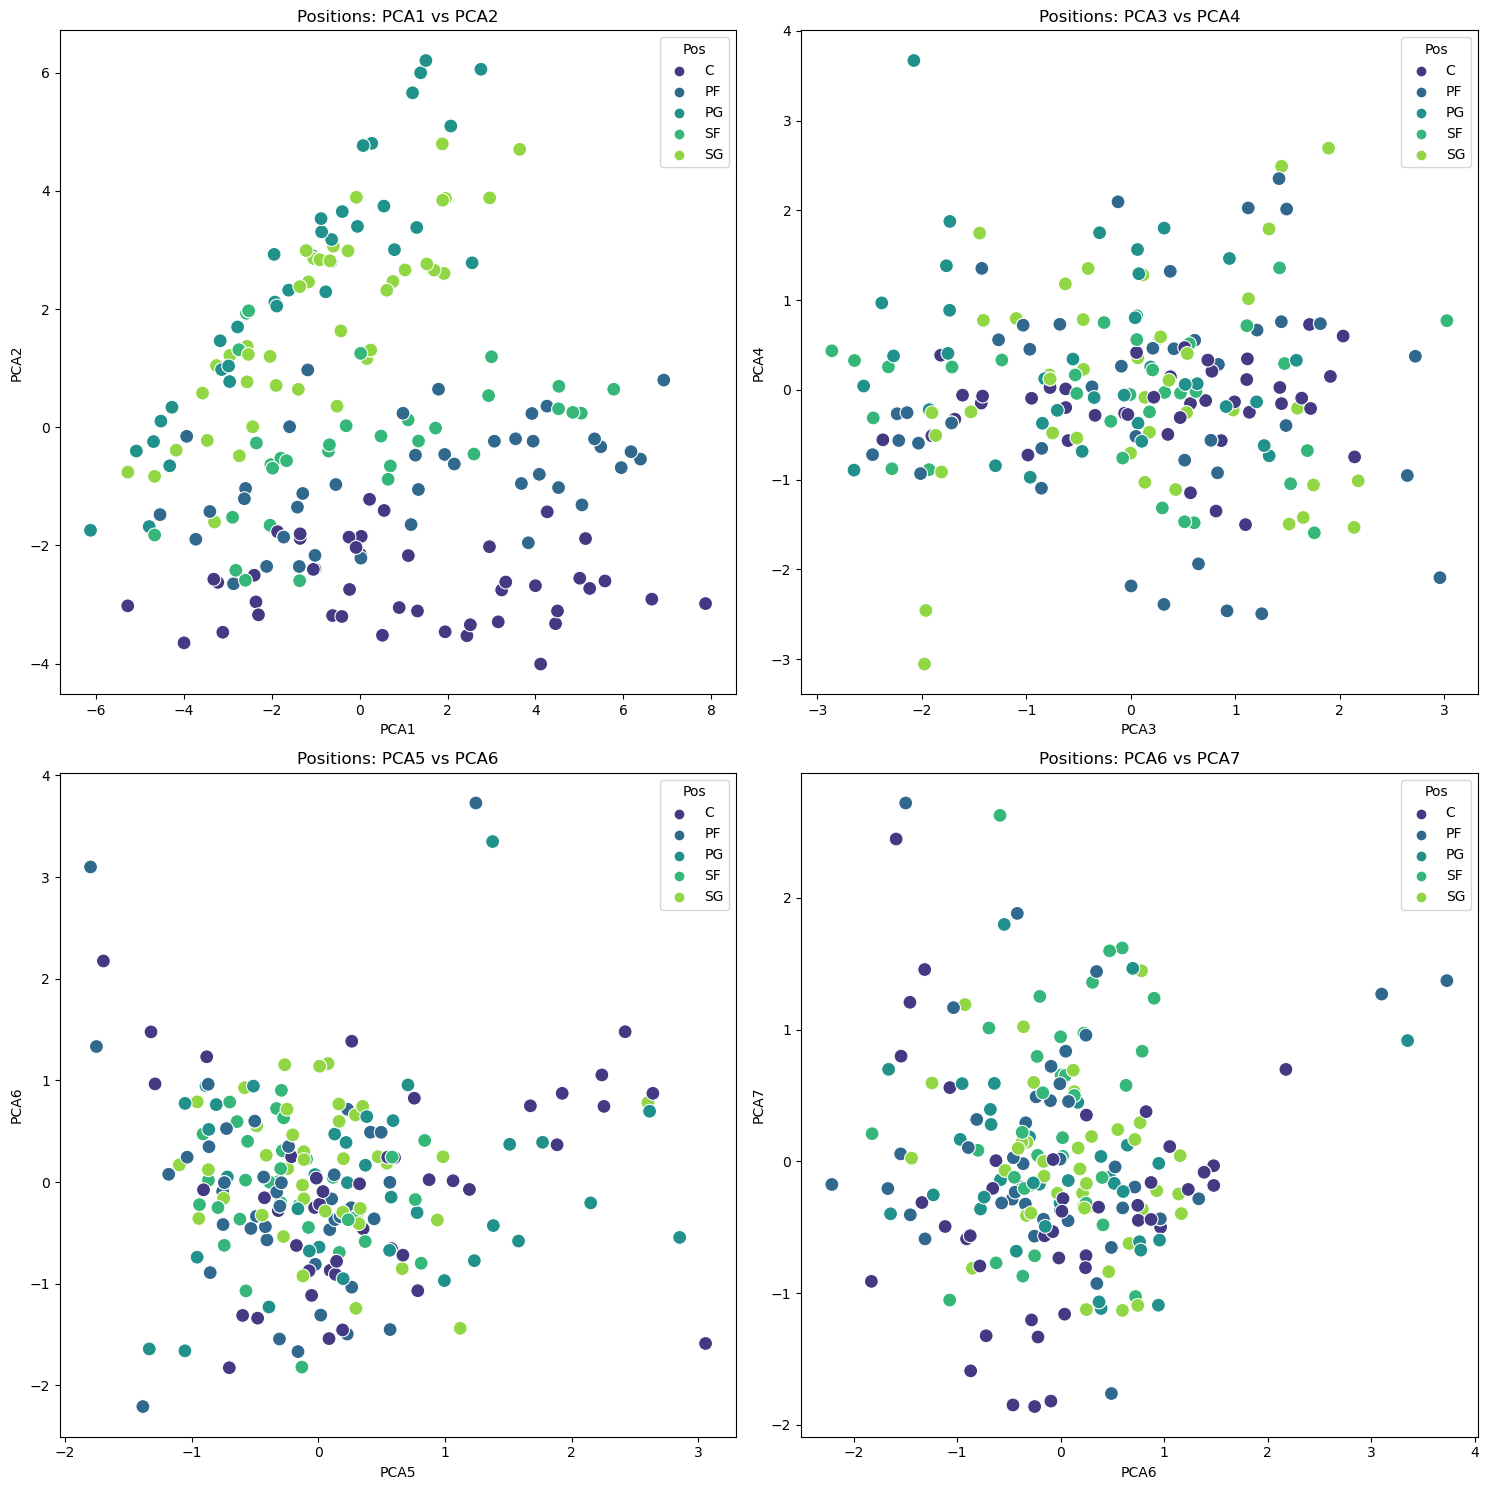

In [256]:
# Visualiser la répartition des positions par rapport aux axes de PCA
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
axes = axes.flatten()

sns.scatterplot(data=exploded_data, x='PCA1', y='PCA2', hue='Pos', palette='viridis', s=100, ax=axes[0])
axes[0].set_title('Positions: PCA1 vs PCA2')
axes[0].set_xlabel('PCA1')
axes[0].set_ylabel('PCA2')

sns.scatterplot(data=exploded_data, x='PCA3', y='PCA4', hue='Pos', palette='viridis', s=100, ax=axes[1])
axes[1].set_title('Positions: PCA3 vs PCA4')
axes[1].set_xlabel('PCA3')
axes[1].set_ylabel('PCA4')

sns.scatterplot(data=exploded_data, x='PCA5', y='PCA6', hue='Pos', palette='viridis', s=100, ax=axes[2])
axes[2].set_title('Positions: PCA5 vs PCA6')
axes[2].set_xlabel('PCA5')
axes[2].set_ylabel('PCA6')

sns.scatterplot(data=exploded_data, x='PCA6', y='PCA7', hue='Pos', palette='viridis', s=100, ax=axes[3])
axes[3].set_title('Positions: PCA6 vs PCA7')
axes[3].set_xlabel('PCA6')
axes[3].set_ylabel('PCA7')

plt.tight_layout()
plt.show()


#### Tracer les cercles de corrélations pour chaque poste par rapport à tous les axes

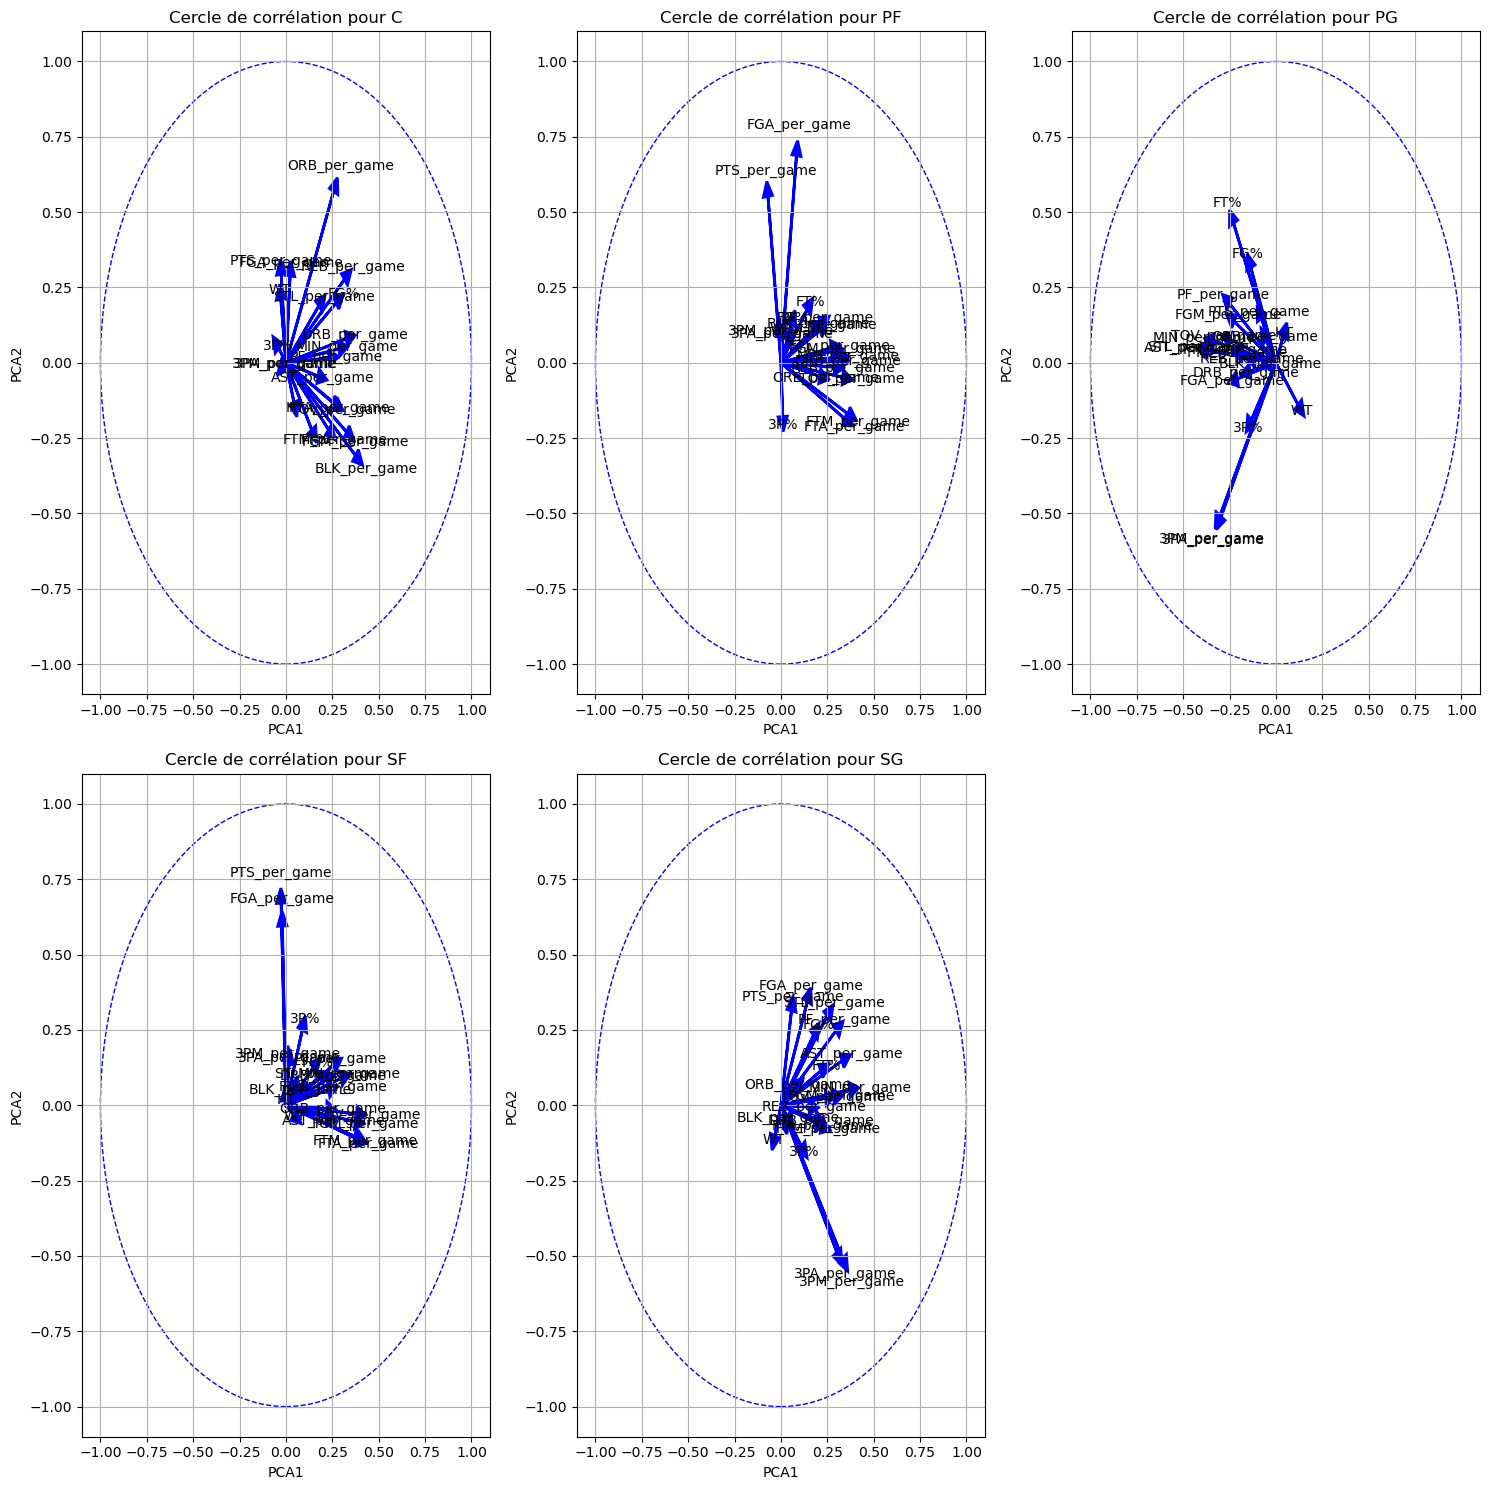

In [257]:
from matplotlib.patches import Ellipse

def plot_correlation_circle(pca, all_cols, ax, title):
    pcs = pca.components_
    for i in range(len(all_cols)):
        ax.arrow(0, 0, pcs[0, i], pcs[1, i], head_width=0.05, head_length=0.05, linewidth=2, color='blue')
        ax.text(pcs[0, i] * 1.15, pcs[1, i] * 1.15, all_cols[i], color='black', ha='center', va='center')
    circle = plt.Circle((0, 0), 1, facecolor='none', edgecolor='b', linestyle='--')
    ax.add_patch(circle)
    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-1.1, 1.1)
    ax.set_xlabel('PCA1')
    ax.set_ylabel('PCA2')
    ax.set_title(title)
    ax.grid()

# Liste des positions uniques
positions = exploded_data['Pos'].unique()

# Définir la taille de la grille
n_cols = 3
n_rows = (len(positions) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15))
axes = axes.flatten()

# Tracer les cercles de corrélations pour chaque poste
for i, pos in enumerate(positions):
    pos_data = exploded_data[exploded_data['Pos'] == pos]
    pos_pca = PCA(n_components=2).fit(scaler.transform(pos_data[all_cols].dropna()))
    plot_correlation_circle(pos_pca, all_cols, axes[i], f'Cercle de corrélation pour {pos}')

# Supprimer les axes vides si le nombre de positions n'est pas un multiple de n_cols
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
